# Demo for processing NIRSpec data from DD-2756 (PI: Pat Kelly)

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import msaexp
from msaexp import pipeline

print(f'msaexp version = {msaexp.__version__}')

msaexp version = 0.3.4


In [2]:
os.getcwd()

'/usr/local/share/python/msaexp/docs/examples'

# Query MAST for NIRSpec data

Query by program name and download `rate.fits` files with `mastquery`.  May need to set `$MAST_TOKEN` environment variable to enable the downloads from MAST.

Can optionally limit the query to specific 

 - gratings:  ``prism``, ``g140m``, ``g235m``, ``g395m``, ``g140m``, ``g235m``, ``g395m``
 - filters:  ``clear``, ``f170lp``, ``f100lp``, ``f170lp``, ``f290lp``
 - detectors: ``nrs1``, ``nrs2``
 
 

In [3]:
# Query NIRSpec data for a program name
masks = pipeline.query_program(2767, download=True, gratings=['prism']) #, detectors=['nrs2'])

2022-11-10 13:23:12,155 - stpipe - INFO - MAST API token accepted, welcome Gabriel Brammer


INFO: MAST API token accepted, welcome Gabriel Brammer [astroquery.mast.auth]


# Initialize pipeline

Exposures are grouped by detector and with a common `MSAMETFL` metadata file for the MSA setup.

In [8]:
groups = pipeline.exposure_groups()
print('\nFiles: ')
for g in groups:
    if '2736' not in g:
        continue
        
    print (f"{g} : {' '.join(groups[g])}")

   N  value     
====  ==========
   3  jw02736007001-01-f170lp-g235m-nrs1
   3  jw02736007001-01-f170lp-g235m-nrs2
   3  jw02736007001-01-f290lp-g395m-nrs1
   3  jw02736007001-01-f290lp-g395m-nrs2
   3  jw02736008001-01-f170lp-g235m-nrs1
   3  jw02736008001-01-f170lp-g235m-nrs2
   3  jw02736008001-01-f290lp-g395m-nrs1
   3  jw02736008001-01-f290lp-g395m-nrs2
   3  jw02767005001-01-f070lp-g140m-nrs1
   3  jw02767005001-01-f070lp-g140m-nrs2
   3  jw02767005001-01-f100lp-g140m-nrs1
   3  jw02767005001-01-f100lp-g140m-nrs2
   3  jw02767005001-02-clear-prism-nrs1
   3  jw02767005001-02-clear-prism-nrs2

Files: 
jw02736007001-01-f170lp-g235m-nrs1 : jw02736007001_03101_00002_nrs1_rate.fits jw02736007001_03101_00003_nrs1_rate.fits jw02736007001_03101_00004_nrs1_rate.fits
jw02736007001-01-f170lp-g235m-nrs2 : jw02736007001_03101_00002_nrs2_rate.fits jw02736007001_03101_00003_nrs2_rate.fits jw02736007001_03101_00004_nrs2_rate.fits
jw02736007001-01-f290lp-g395m-nrs1 : jw02736007001_03103_00001_nr

In [9]:
pipe = pipeline.NirspecPipeline(mode='jw02767005001-02-clear-prism-nrs2')

# (2022-11-10 12:24:36.232)
msaexp.NirspecPipeline: Initialize jw02767005001-02-clear-prism-nrs2
msaexp.NirspecPipeline: jw02767005001_03105_00002_nrs2_rate.fits
msaexp.NirspecPipeline: jw02767005001_03105_00003_nrs2_rate.fits
msaexp.NirspecPipeline: jw02767005001_03105_00004_nrs2_rate.fits


## Preprocessing pipeline

1. Run 1/f correction and identify "snowballs" on the `rate.fits` files
2. Remove "bias" (i.e., simple median) of each exposure
3. Run parts of the Level 2 JWST calibration pipeline ([calweb_spec2](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec2.html#calwebb-spec2)):
  - [AssignWcs](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.assign_wcs.AssignWcsStep.html) : initialize WCS and populate slit bounding_box data
  - [Extract2dStep](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.extract_2d.Extract2dStep.html) : identify slits and set slit WCS
  - [FlatFieldStep](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.flatfield.FlatFieldStep.html#flatfieldstep) : slit-level flat field
  - [PathLossStep](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.pathloss.PathLossStep.html) : NIRSpec path loss
  - [PhotomStep](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.photom.PhotomStep.html) : Photometric calibration
  
  Note that the `srctype`, `master_background`, `wavecorr` steps are not performed.  The background subtraction is done manually on the 2D slit cutouts.
  
4. Parse slit metadata
5. Save slit cutout files of the last pipeline step performed (`phot` = `PhotomStep`)

Subsequent re-initialization of the `NirspecPipeline` object and `full_pipeline` method will skip these steps and just load the saved slit cutouts.

In [11]:
# Run the pipeline to define slits, etc., but don't do extractions yet.  
if not os.path.exists(f'{pipe.mode}.slits.yaml'):
    pipe.full_pipeline(run_extractions=False)
else:
    print('Skip preprocessing')

Skip preprocessing


In [13]:
import glob
files = glob.glob(f'{pipe.mode}*')
files.sort()
for f in files:
    print(f)

jw02767005001-02-clear-prism-nrs2.log.txt
jw02767005001-02-clear-prism-nrs2.reg
jw02767005001-02-clear-prism-nrs2.slits.yaml


In [15]:
# Parse slit polygons
# try to use the slitlet WCS to generate a polygon in sky coordinates of the slit locations
# if not os.path.exists('jw02767005001-02-clear-prism-nrs2.slits.reg'):
#    pipe.get_slit_polygons()

## Pipeline products

In [16]:
print('Pipeline entries: ', list(pipe.pipe.keys()))
print('Last step: ', pipe.last_step)

Pipeline entries:  []
Last step:  None


# Reinitialize with limited set of targets

In [17]:
targets = ['2767_11027', # z=9.5 galaxy from Williams et al.
           '2767_2740', # z=1.14
          ]

pipe = pipeline.NirspecPipeline(mode='jw02767005001-02-clear-prism-nrs2')
pipe.full_pipeline(run_extractions=False, targets=targets)

# (2022-11-10 12:25:22.991)
msaexp.NirspecPipeline: Initialize jw02767005001-02-clear-prism-nrs2
msaexp.NirspecPipeline: jw02767005001_03105_00002_nrs2_rate.fits
msaexp.NirspecPipeline: jw02767005001_03105_00003_nrs2_rate.fits
msaexp.NirspecPipeline: jw02767005001_03105_00004_nrs2_rate.fits
msaexp.read_data: jw02767005001_03105_00002_nrs2_phot.072.2767_11027.fits background_109
msaexp.read_data: jw02767005001_03105_00002_nrs2_phot.082.2767_2740.fits background_128
msaexp.read_data: jw02767005001_03105_00003_nrs2_phot.072.2767_11027.fits 2767_11027
msaexp.read_data: jw02767005001_03105_00003_nrs2_phot.082.2767_2740.fits 2767_2740
msaexp.read_data: jw02767005001_03105_00004_nrs2_phot.072.2767_11027.fits background_109
msaexp.read_data: jw02767005001_03105_00004_nrs2_phot.082.2767_2740.fits background_128
# slit_index slitlet_id  source_name  source_ra  source_dec
# jw02767005001-02-clear-prism-nrs2
# Get slitlet data from jw02767005001-02-clear-prism-nrs2.slits.yaml
  72   109   2767_110

## Slitlet metadata

In [19]:
pipe.targets

['2767_11027', '2767_2740']

# Extract spectra

yoffset : offset in pixels relative to where the slit WCS thinks the target coordinates should be
prof_sigma : gaussian profile sigma width
skip : list of indices to exclude from the combination to avoid bad pixels, misalignment, etc.

2022-11-10 13:27:02,703 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/msatest/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,



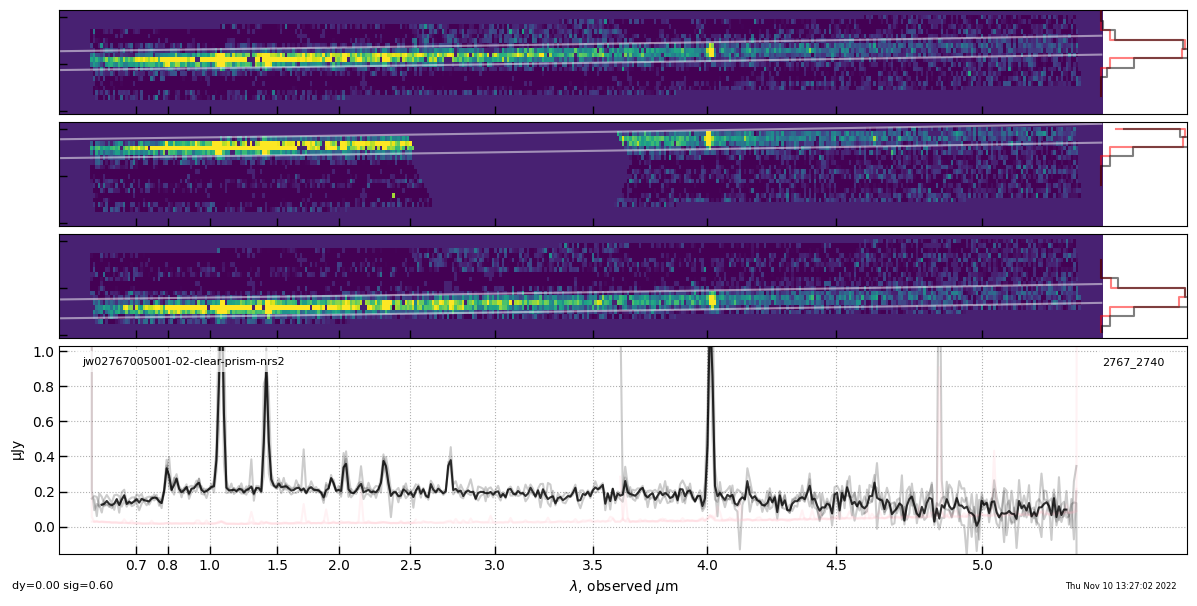

In [20]:
key = '2767_11027' # z=9.5 galaxy from Williams et al.
key = '2767_2740' # z=1.14 with lines

_ = pipe.extract_spectrum(key, skip=[], yoffset=0, prof_sigma=0.6, trace_sign=-1, fit_profile_params=None)

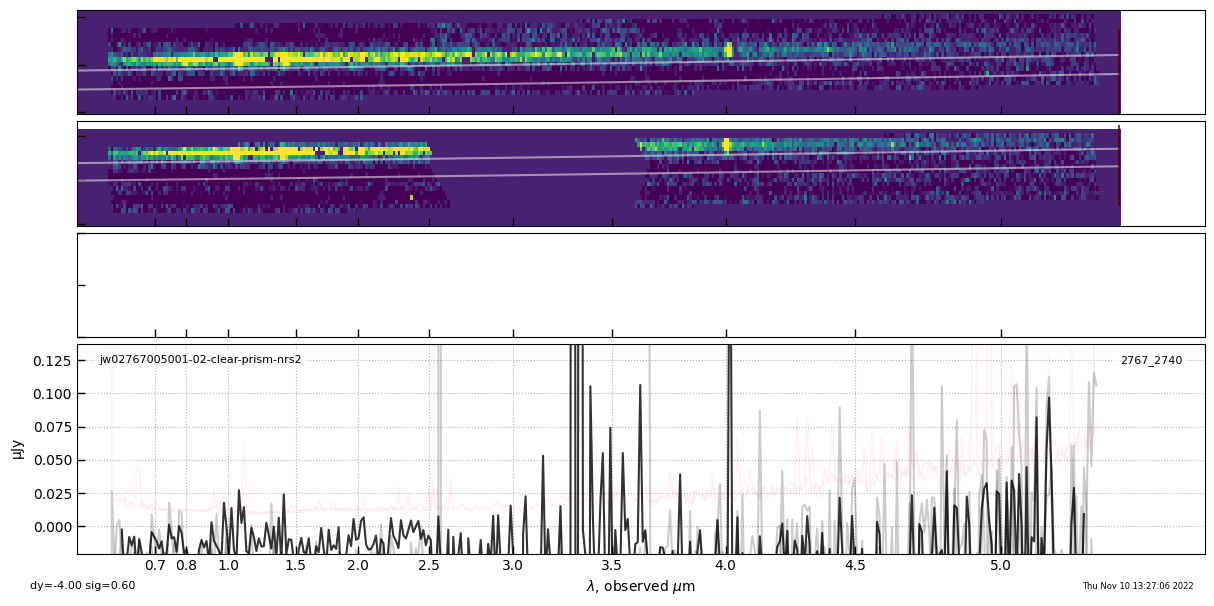

In [21]:
# Shift the extraction along the slit (bad here)
_ = pipe.extract_spectrum(key, skip=[], yoffset=-4, prof_sigma=0.6, trace_sign=-1, fit_profile_params=None)

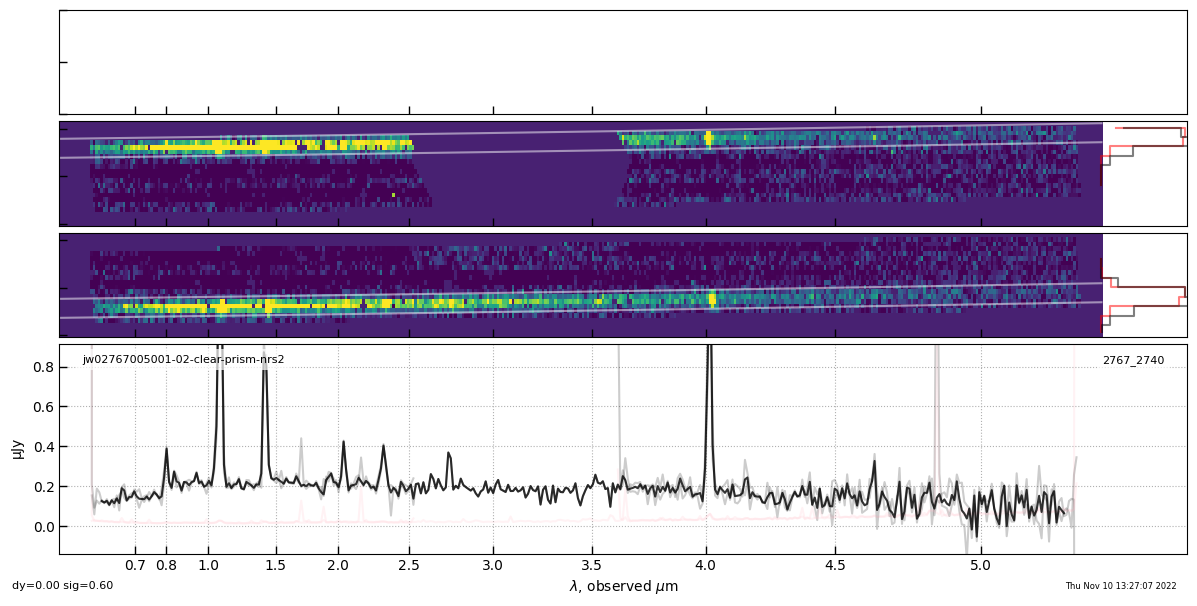

In [22]:
# Exclude first exposure
_ = pipe.extract_spectrum(key, skip=[0], yoffset=0, prof_sigma=0.6, trace_sign=-1, fit_profile_params=None)

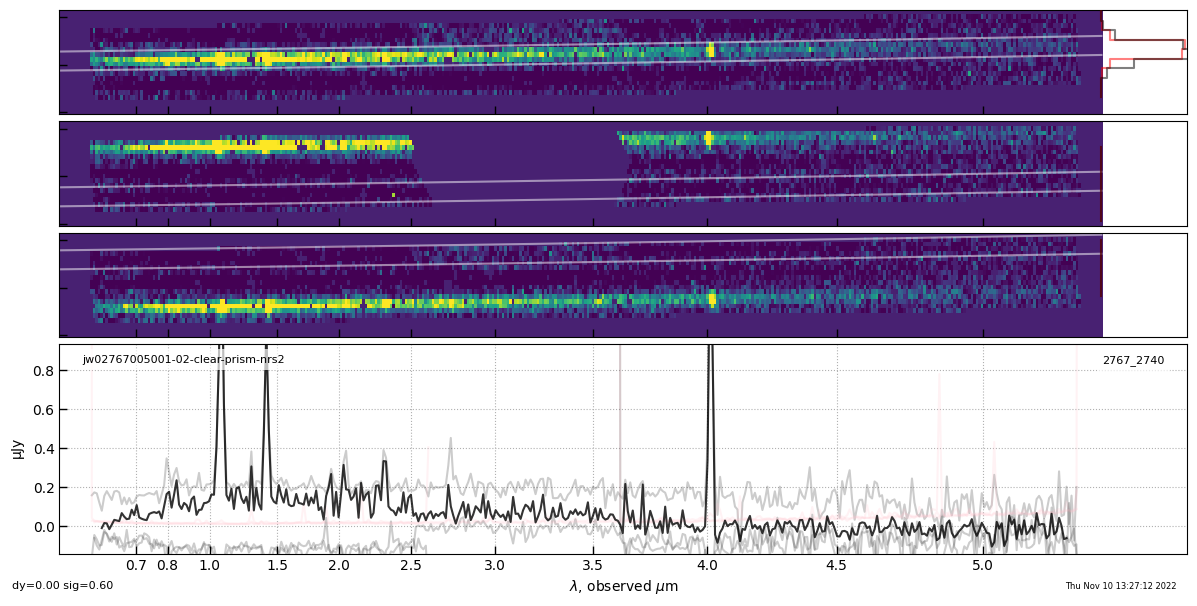

In [23]:
# Not quite sure why the sign flips
# maybe sign=-1 for prism, +1 otherwise?
_ = pipe.extract_spectrum(key, skip=[], yoffset=0, prof_sigma=0.6, trace_sign=1, fit_profile_params=None)

2022-11-10 13:27:16,595 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/msatest/lib/python3.9/site-packages/msaexp/pipeline.py:668: OptimizeWarning: Unknown solver options: direc
  _res = minimize(_objfun_fit_profile, x0,



msaexp.fit_profile:      2767_2740             (dchi2 =   8207.1) yoffset = -0.16  prof_sigma = 0.69 dchi2 =    596.2


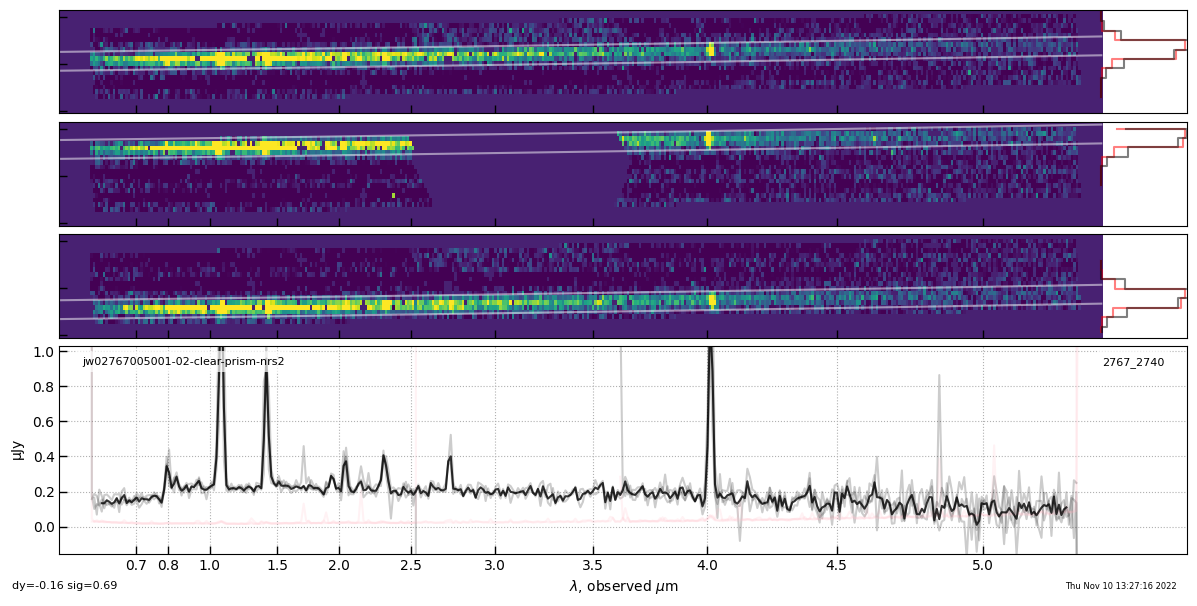

In [24]:
# Fit optimal profile
_data = pipe.extract_spectrum(key, skip=[], yoffset=0, prof_sigma=0.6, trace_sign=-1, 
                              fit_profile_params={'min_delta':20})
slitlet, sep1d, opt1d, fig = _data

## Drizzled 2D spectrum

In [25]:
# Get background-subtracted slitlets
slits = pipe.get_background_slits(key, step='bkg', check_background=True)
len(slits)

3

In [26]:
import msaexp.utils

drizzle_params = dict(output=None,
                      single=True,
                      blendheaders=True,
                      pixfrac=0.5,
                      kernel='square',
                      fillval=0,
                      wht_type='ivm',
                      good_bits=0,
                      pscale_ratio=1.0,
                      pscale=None)

# Drizzle each exposure
kwargs = {'keep_wave':1}
wave, header, results = msaexp.utils.drizzle_slits_2d(slits, drizzle_params=drizzle_params, **kwargs)


build_regular_wavelength_wcs: Set linear wave grid (dlam=103.2 Ang)
Pad 2 pixels on 2D cutout


2022-11-10 13:27:24,664 - stpipe - INFO - Driz parameter kernal: square
2022-11-10 13:27:24,664 - stpipe - INFO - Driz parameter pixfrac: 0.5
2022-11-10 13:27:24,664 - stpipe - INFO - Driz parameter fillval: 0
2022-11-10 13:27:24,664 - stpipe - INFO - Driz parameter weight_type: ivm
2022-11-10 13:27:25,028 - stpipe - INFO - Blending metadata for None
2022-11-10 13:27:25,730 - stpipe - INFO - Resampling science data
2022-11-10 13:27:25,757 - stpipe - INFO - Drizzling (22, 419) --> (32, 421)
2022-11-10 13:27:25,758 - stpipe - INFO - Resampling var_rnoise
2022-11-10 13:27:25,786 - stpipe - INFO - Drizzling (22, 419) --> (32, 421)
2022-11-10 13:27:25,789 - stpipe - INFO - Resampling var_poisson
2022-11-10 13:27:25,814 - stpipe - INFO - Drizzling (22, 419) --> (32, 421)
2022-11-10 13:27:25,816 - stpipe - INFO - Resampling var_flat
2022-11-10 13:27:25,847 - stpipe - INFO - Drizzling (22, 419) --> (32, 421)
2022-11-10 13:27:26,205 - stpipe - INFO - Blending metadata for None
2022-11-10 13:27:

In [27]:
# Combine drizzled products with outlier rejection
prf_kwargs = {'prf_center':None, 'prf_sigma':0.6, 'fit_prf':True}
sci2d, wht2d, p2d, spec, prof = msaexp.utils.combine_2d_with_rejection(results, outlier_threshold=5, **prf_kwargs)

2022-11-10 13:27:33,406 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/msatest/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,



Set prf_center: 1.0 (32, 421) 6
fit_prf: center = 1.00. sigma = 0.78


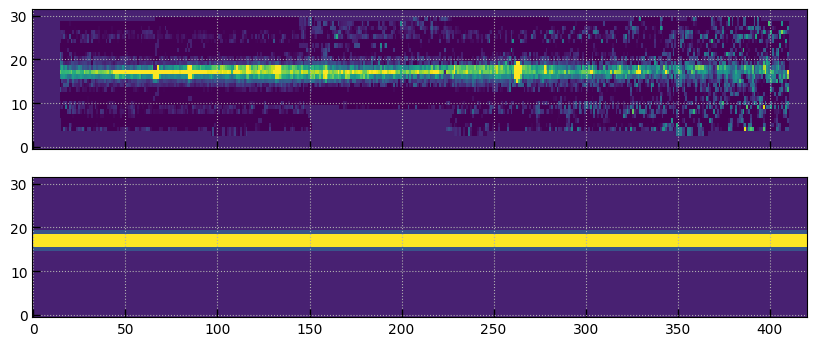

In [28]:
fig, axes = plt.subplots(2,1,figsize=(10,4), sharex=True)
axes[0].imshow(sci2d, vmin=-0.01, vmax=0.1, origin='lower', aspect='auto')
axes[1].imshow(p2d, vmin=-0.01, vmax=0.1, origin='lower', aspect='auto')
for ax in axes:
    ax.grid()

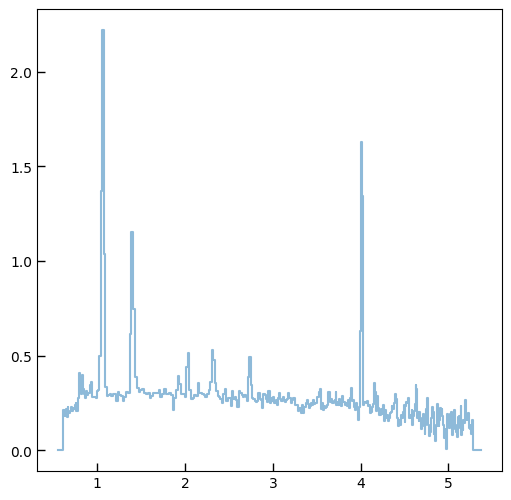

In [29]:
plt.step(spec['wave'], spec['flux'], alpha=0.5)

In [30]:
# Drizzle to a grid that oversamples the wavelengths by x2
kwargs = {'keep_wave':2}
wave2, header2, results2 = msaexp.utils.drizzle_slits_2d(slits, drizzle_params=drizzle_params, **kwargs)

build_regular_wavelength_wcs: Oversample original wavelength grid x 2
Pad 2 pixels on 2D cutout


2022-11-10 13:27:37,257 - stpipe - INFO - Driz parameter kernal: square
2022-11-10 13:27:37,257 - stpipe - INFO - Driz parameter pixfrac: 0.5
2022-11-10 13:27:37,258 - stpipe - INFO - Driz parameter fillval: 0
2022-11-10 13:27:37,258 - stpipe - INFO - Driz parameter weight_type: ivm
2022-11-10 13:27:37,631 - stpipe - INFO - Blending metadata for None
2022-11-10 13:27:38,341 - stpipe - INFO - Resampling science data
2022-11-10 13:27:38,369 - stpipe - INFO - Drizzling (22, 419) --> (32, 841)
2022-11-10 13:27:38,371 - stpipe - INFO - Resampling var_rnoise
2022-11-10 13:27:38,399 - stpipe - INFO - Drizzling (22, 419) --> (32, 841)
2022-11-10 13:27:38,402 - stpipe - INFO - Resampling var_poisson
2022-11-10 13:27:38,431 - stpipe - INFO - Drizzling (22, 419) --> (32, 841)
2022-11-10 13:27:38,433 - stpipe - INFO - Resampling var_flat
2022-11-10 13:27:38,463 - stpipe - INFO - Drizzling (22, 419) --> (32, 841)
2022-11-10 13:27:38,673 - stpipe - INFO - Blending metadata for None
2022-11-10 13:27:

In [31]:
prf_kwargs = {'prf_center':None, 'prf_sigma':0.6, 'fit_prf':True}
sci2d2, wht2d2, p2d2, spec2, prof = msaexp.utils.combine_2d_with_rejection(results2, sigma=5, **prf_kwargs)

2022-11-10 13:27:40,711 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/msatest/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,



Set prf_center: 1.0 (32, 841) 6
fit_prf: center = 1.01. sigma = 0.75


(3.9, 4.1)

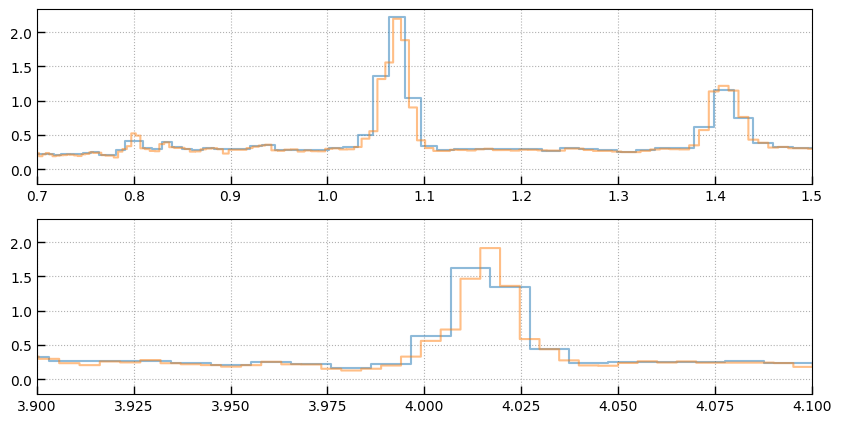

In [32]:
fig, axes = plt.subplots(2,1, figsize=(10, 5))
for ax in axes:
    ax.step(spec['wave'], spec['flux'], alpha=0.5, where='mid')
    ax.step(spec2['wave'], spec2['flux'], alpha=0.5, where='mid')
    ax.grid()

axes[0].set_xlim(0.7, 1.5)
axes[1].set_xlim(3.9, 4.1)

# 2D drizzle helper

`msaexp.utils.drizzle_2d_pipeline` does the 2D drizzle steps above and wraps the output into a FITS HDU

In [33]:
from importlib import reload
reload(msaexp.utils)

import grizli.utils
grizli.utils.set_warnings()

DRIZZLE_PARAMS = dict(output=None,
                      single=True,
                      blendheaders=True,
                      pixfrac=0.6,
                      kernel='square',
                      fillval=0,
                      wht_type='ivm',
                      good_bits=0,
                      pscale_ratio=1.0,
                      pscale=None)

slits = pipe.get_background_slits(key, step='bkg', check_background=True)

hdul = msaexp.utils.drizzle_2d_pipeline(slits, drizzle_params=DRIZZLE_PARAMS,
                                        fit_prf=True,
                                        outlier_threshold=5,
                                        prf_center=None, prf_sigma=0.6, center_limit=4, 
                                        standard_waves=1)

build_regular_wavelength_wcs: Set user-defined wavelength grid (size=414)
Pad 2 pixels on 2D cutout


2022-11-10 13:27:41,242 - stpipe - INFO - Driz parameter kernal: square
2022-11-10 13:27:41,243 - stpipe - INFO - Driz parameter pixfrac: 0.6
2022-11-10 13:27:41,243 - stpipe - INFO - Driz parameter fillval: 0
2022-11-10 13:27:41,243 - stpipe - INFO - Driz parameter weight_type: ivm
2022-11-10 13:27:41,607 - stpipe - INFO - Blending metadata for None
2022-11-10 13:27:42,455 - stpipe - INFO - Resampling science data
2022-11-10 13:27:42,485 - stpipe - INFO - Drizzling (22, 419) --> (32, 414)
2022-11-10 13:27:42,487 - stpipe - INFO - Resampling var_rnoise
2022-11-10 13:27:42,520 - stpipe - INFO - Drizzling (22, 419) --> (32, 414)
2022-11-10 13:27:42,523 - stpipe - INFO - Resampling var_poisson
2022-11-10 13:27:42,554 - stpipe - INFO - Drizzling (22, 419) --> (32, 414)
2022-11-10 13:27:42,557 - stpipe - INFO - Resampling var_flat
2022-11-10 13:27:42,585 - stpipe - INFO - Drizzling (22, 419) --> (32, 414)
2022-11-10 13:27:42,801 - stpipe - INFO - Blending metadata for None
2022-11-10 13:27:

Set prf_center: 1.0 (32, 414) 6
fit_prf: center = 1.01. sigma = 0.75


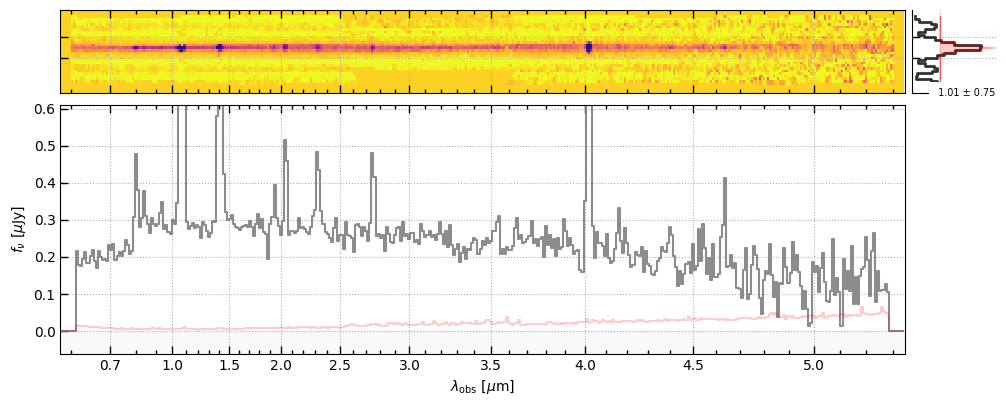

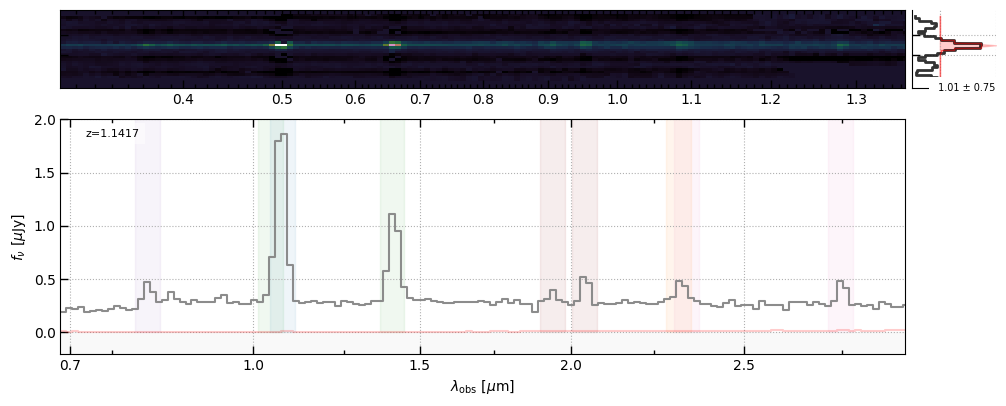

In [34]:
# Make figures showing 2D / 1D spectra
_fig = msaexp.utils.drizzled_hdu_figure(hdul, xlim=None)

# Other plot options
_fig = msaexp.utils.drizzled_hdu_figure(hdul, xlim=(0.69, 2.9), # zoom on wavelength range
                                        tick_steps=[0.5, 0.25], # major, minor
                                        ymax=2,   # y extent of plot and 2D scaling
                                        z=1.1417, # indicate strong lines for a given redshift
                                        cmap='cubehelix')


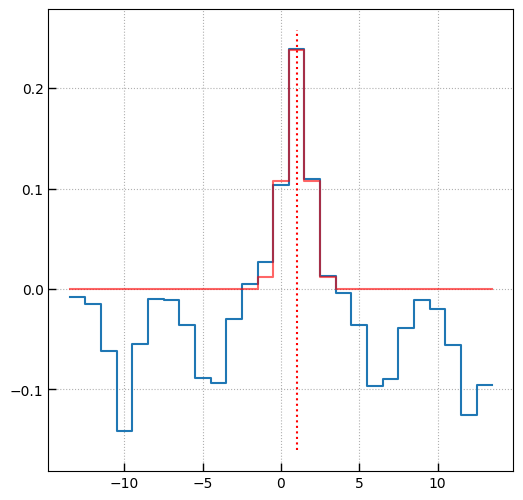

In [35]:
# Show the optimal extraction profile

plt.step(prof['pix'], prof['profile'], where='mid', label='Profile data')
plt.step(prof['pix'], prof['pfit'], where='mid', label='Profile data', color='r', alpha=0.6)

plt.vlines(prof.meta['PROFCEN'][0], *plt.ylim(), color='r', linestyle=':')
plt.grid()

In [ ]:
# Stop the notebook if "Run All"
break

# Process all groups

In [10]:
groups = pipeline.exposure_groups()
groups

for mode in groups:
    if ('02767' in mode): # & (not os.path.exists(f'{mode}.slits.yaml')):
        # Run the pipeline to define slits, etc., but don't do extractions yet.  
        pipe = pipeline.NirspecPipeline(mode=mode)
        pipe.full_pipeline(run_extractions=False, initialize_bkg=False)
    else:
        print(f'Skip {mode}')

   N  value     
====  ==========
   3  jw02736007001-01-f170lp-g235m-nrs1
   3  jw02736007001-01-f170lp-g235m-nrs2
   3  jw02736007001-01-f290lp-g395m-nrs1
   3  jw02736007001-01-f290lp-g395m-nrs2
   3  jw02736008001-01-f170lp-g235m-nrs1
   3  jw02736008001-01-f170lp-g235m-nrs2
   3  jw02736008001-01-f290lp-g395m-nrs1
   3  jw02736008001-01-f290lp-g395m-nrs2
   3  jw02767005001-02-clear-prism-nrs1
   3  jw02767005001-02-clear-prism-nrs2
Skip jw02736007001-01-f170lp-g235m-nrs1
Skip jw02736007001-01-f170lp-g235m-nrs2
Skip jw02736007001-01-f290lp-g395m-nrs1
Skip jw02736007001-01-f290lp-g395m-nrs2
Skip jw02736008001-01-f170lp-g235m-nrs1
Skip jw02736008001-01-f170lp-g235m-nrs2
Skip jw02736008001-01-f290lp-g395m-nrs1
Skip jw02736008001-01-f290lp-g395m-nrs2
# (2022-11-10 10:56:02.742)
msaexp.NirspecPipeline: Initialize jw02767005001-02-clear-prism-nrs1
msaexp.NirspecPipeline: jw02767005001_03105_00002_nrs1_rate.fits
msaexp.NirspecPipeline: jw02767005001_03105_00003_nrs1_rate.fits
msaexp.Nirs

2022-11-10 11:56:03,301 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/msatest/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1095: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)



exposure_oneoverf_correction: jw02767005001_03105_00002_nrs1_rate.fits apply to file
exposure_oneoverf_correction: jw02767005001_03105_00003_nrs1_rate.fits axis=0
exposure_oneoverf_correction: jw02767005001_03105_00003_nrs1_rate.fits apply to file
exposure_oneoverf_correction: jw02767005001_03105_00004_nrs1_rate.fits axis=0
exposure_oneoverf_correction: jw02767005001_03105_00004_nrs1_rate.fits apply to file
# (2022-11-10 10:56:05.272)
msaexp.preprocess : bias level jw02767005001_03105_00002_nrs1_rate.fits = 0.0031


2022-11-10 11:56:05,544 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


# (2022-11-10 10:56:05.388)
msaexp.preprocess : bias level jw02767005001_03105_00003_nrs1_rate.fits = 0.0027
# (2022-11-10 10:56:05.498)
msaexp.preprocess : bias level jw02767005001_03105_00004_nrs1_rate.fits = 0.0009


2022-11-10 11:56:08,326 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.
2022-11-10 11:56:08,373 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args (<ImageModel(2048, 2048) from jw02767005001_03105_00002_nrs1_rate.fits>,).
2022-11-10 11:56:08,374 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.1, 'sip_degree': None, 'sip_max_inv_pix_error': 0.1, 'sip_inv_degree': None, 'sip_npoints': 12, 'slit_y_low': -0.55, 'slit_y_high': 0.55}
2022-11-10 11:56:08,648 - stpipe.AssignWcsStep - INFO - Retrieving open MSA slitlets for msa_metadata_id = 67 and dither_index = 1
2022-11-10 11:56:08,679 - stpipe.AssignWcsStep - INFO - Slitlet_id 71 is background only;

2022-11-10 11:56:09,877 - stpipe.AssignWcsStep - INFO - Slitlet_id 245 is background only; assigned source_id = 11090
2022-11-10 11:56:09,884 - stpipe.AssignWcsStep - INFO - Slitlet_id 246 is background only; assigned source_id = 11091
2022-11-10 11:56:09,891 - stpipe.AssignWcsStep - INFO - Slitlet_id 247 is background only; assigned source_id = 11092
2022-11-10 11:56:09,899 - stpipe.AssignWcsStep - INFO - Slitlet_id 248 is background only; assigned source_id = 11093
2022-11-10 11:56:09,906 - stpipe.AssignWcsStep - INFO - Slitlet_id 249 is background only; assigned source_id = 11094
2022-11-10 11:56:09,913 - stpipe.AssignWcsStep - INFO - Slitlet_id 250 is background only; assigned source_id = 11095
2022-11-10 11:56:09,920 - stpipe.AssignWcsStep - INFO - Slitlet_id 251 is background only; assigned source_id = 11096
2022-11-10 11:56:10,107 - stpipe.AssignWcsStep - INFO - gwa_ytilt is 0.03236998999999953 deg
2022-11-10 11:56:10,107 - stpipe.AssignWcsStep - INFO - gwa_xtilt is 0.3355620500

2022-11-10 11:56:12,291 - stpipe.AssignWcsStep - INFO - Removing slit 72 from the list of open slits because the WCS bounding_box is completely outside the detector.
2022-11-10 11:56:12,319 - stpipe.AssignWcsStep - INFO - Removing slit 74 from the list of open slits because the WCS bounding_box is completely outside the detector.
2022-11-10 11:56:12,347 - stpipe.AssignWcsStep - INFO - Removing slit 75 from the list of open slits because the WCS bounding_box is completely outside the detector.
2022-11-10 11:56:12,381 - stpipe.AssignWcsStep - INFO - Removing slit 81 from the list of open slits because the WCS bounding_box is completely outside the detector.
2022-11-10 11:56:12,413 - stpipe.AssignWcsStep - INFO - Removing slit 86 from the list of open slits because the WCS bounding_box is completely outside the detector.
2022-11-10 11:56:12,441 - stpipe.AssignWcsStep - INFO - Removing slit 87 from the list of open slits because the WCS bounding_box is completely outside the detector.
2022

2022-11-10 11:56:16,513 - stpipe.AssignWcsStep - INFO - There are 47 open slits in quadrant 4
2022-11-10 11:56:16,711 - stpipe.AssignWcsStep - INFO - There are 0 open slits in quadrant 5
2022-11-10 11:56:17,263 - stpipe.AssignWcsStep - INFO - Created a NIRSPEC nrs_msaspec pipeline with references {'distortion': None, 'filteroffset': None, 'specwcs': None, 'regions': None, 'wavelengthrange': '/Users/gbrammer/Research/grizli/crds_cache/references/jwst/nirspec/jwst_nirspec_wavelengthrange_0006.asdf', 'camera': '/Users/gbrammer/Research/grizli/crds_cache/references/jwst/nirspec/jwst_nirspec_camera_0008.asdf', 'collimator': '/Users/gbrammer/Research/grizli/crds_cache/references/jwst/nirspec/jwst_nirspec_collimator_0008.asdf', 'disperser': '/Users/gbrammer/Research/grizli/crds_cache/references/jwst/nirspec/jwst_nirspec_disperser_0065.asdf', 'fore': '/Users/gbrammer/Research/grizli/crds_cache/references/jwst/nirspec/jwst_nirspec_fore_0054.asdf', 'fpa': '/Users/gbrammer/Research/grizli/crds_ca

2022-11-10 11:56:20,515 - stpipe.AssignWcsStep - INFO - Slitlet_id 231 is background only; assigned source_id = 11077
2022-11-10 11:56:20,522 - stpipe.AssignWcsStep - INFO - Slitlet_id 232 is background only; assigned source_id = 11078
2022-11-10 11:56:20,529 - stpipe.AssignWcsStep - INFO - Slitlet_id 233 is background only; assigned source_id = 11079
2022-11-10 11:56:20,536 - stpipe.AssignWcsStep - INFO - Slitlet_id 234 is background only; assigned source_id = 11080
2022-11-10 11:56:20,543 - stpipe.AssignWcsStep - INFO - Slitlet_id 235 is background only; assigned source_id = 11081
2022-11-10 11:56:20,550 - stpipe.AssignWcsStep - INFO - Slitlet_id 236 is background only; assigned source_id = 11082
2022-11-10 11:56:20,557 - stpipe.AssignWcsStep - INFO - Slitlet_id 237 is background only; assigned source_id = 11083
2022-11-10 11:56:20,564 - stpipe.AssignWcsStep - INFO - Slitlet_id 238 is background only; assigned source_id = 11084
2022-11-10 11:56:20,571 - stpipe.AssignWcsStep - INFO - 

2022-11-10 11:56:22,274 - stpipe.AssignWcsStep - INFO - Removing slit 132 from the list of open slits because the WCS bounding_box is completely outside the detector.
2022-11-10 11:56:22,306 - stpipe.AssignWcsStep - INFO - Removing slit 133 from the list of open slits because the WCS bounding_box is completely outside the detector.
2022-11-10 11:56:22,330 - stpipe.AssignWcsStep - INFO - Removing slit 135 from the list of open slits because the WCS bounding_box is completely outside the detector.
2022-11-10 11:56:22,352 - stpipe.AssignWcsStep - INFO - Removing slit 136 from the list of open slits because the WCS bounding_box is completely outside the detector.
2022-11-10 11:56:22,404 - stpipe.AssignWcsStep - INFO - Removing slit 140 from the list of open slits because the WCS bounding_box is completely outside the detector.
2022-11-10 11:56:22,507 - stpipe.AssignWcsStep - INFO - Removing slit 146 from the list of open slits because the WCS bounding_box is completely outside the detector

2022-11-10 11:56:26,095 - stpipe.AssignWcsStep - INFO - Slits projected on detector NRS1: [139, 141, 142, 143, 149, 153, 154, 155, 156, 157, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251]
2022-11-10 11:56:26,095 - stpipe.AssignWcsStep - INFO - Computing WCS for 102 open slitlets
2022-11-10 11:56:26,263 - stpipe.AssignWcsStep - INFO - gwa_ytilt is 0.03236998999999953 deg
2022-11-10 11:56:26,264 - stpipe.AssignWcsStep - INFO - gwa_xtilt is 0.3355620500000074 deg
2022-11-10 11:56:26,264 - stpipe.AssignWcsStep - INFO - theta_y correction: 0.005024324185132704 deg
2022-11-10 11:56:26,2

2022-11-10 11:56:31,203 - stpipe.AssignWcsStep - INFO - Slitlet_id 209 is background only; assigned source_id = 11063
2022-11-10 11:56:31,210 - stpipe.AssignWcsStep - INFO - Slitlet_id 210 is background only; assigned source_id = 11064
2022-11-10 11:56:31,230 - stpipe.AssignWcsStep - INFO - Slitlet_id 213 is background only; assigned source_id = 11065
2022-11-10 11:56:31,245 - stpipe.AssignWcsStep - INFO - Slitlet_id 215 is background only; assigned source_id = 11066
2022-11-10 11:56:31,265 - stpipe.AssignWcsStep - INFO - Slitlet_id 218 is background only; assigned source_id = 11067
2022-11-10 11:56:31,272 - stpipe.AssignWcsStep - INFO - Slitlet_id 219 is background only; assigned source_id = 11068
2022-11-10 11:56:31,279 - stpipe.AssignWcsStep - INFO - Slitlet_id 220 is background only; assigned source_id = 11069
2022-11-10 11:56:31,287 - stpipe.AssignWcsStep - INFO - Slitlet_id 221 is background only; assigned source_id = 11070
2022-11-10 11:56:31,294 - stpipe.AssignWcsStep - INFO - 

2022-11-10 11:56:32,876 - stpipe.AssignWcsStep - INFO - Removing slit 113 from the list of open slits because the WCS bounding_box is completely outside the detector.
2022-11-10 11:56:32,900 - stpipe.AssignWcsStep - INFO - Removing slit 114 from the list of open slits because the WCS bounding_box is completely outside the detector.
2022-11-10 11:56:32,928 - stpipe.AssignWcsStep - INFO - Removing slit 115 from the list of open slits because the WCS bounding_box is completely outside the detector.
2022-11-10 11:56:32,957 - stpipe.AssignWcsStep - INFO - Removing slit 117 from the list of open slits because the WCS bounding_box is completely outside the detector.
2022-11-10 11:56:32,985 - stpipe.AssignWcsStep - INFO - Removing slit 119 from the list of open slits because the WCS bounding_box is completely outside the detector.
2022-11-10 11:56:33,012 - stpipe.AssignWcsStep - INFO - Removing slit 120 from the list of open slits because the WCS bounding_box is completely outside the detector

2022-11-10 11:56:34,549 - stpipe.AssignWcsStep - INFO - Removing slit 137 from the list of open slits because the WCS bounding_box is completely outside the detector.
2022-11-10 11:56:34,581 - stpipe.AssignWcsStep - INFO - Removing slit 138 from the list of open slits because the WCS bounding_box is completely outside the detector.
2022-11-10 11:56:34,606 - stpipe.AssignWcsStep - INFO - Removing slit 144 from the list of open slits because the WCS bounding_box is completely outside the detector.
2022-11-10 11:56:34,634 - stpipe.AssignWcsStep - INFO - Removing slit 145 from the list of open slits because the WCS bounding_box is completely outside the detector.
2022-11-10 11:56:34,666 - stpipe.AssignWcsStep - INFO - Removing slit 147 from the list of open slits because the WCS bounding_box is completely outside the detector.
2022-11-10 11:56:34,690 - stpipe.AssignWcsStep - INFO - Removing slit 148 from the list of open slits because the WCS bounding_box is completely outside the detector

# (2022-11-10 10:56:40.339)
msaexp.jwst.MSAFlagOpenStep: jw02767005001_03105_00002_nrs1_rate.fits


2022-11-10 11:56:40,571 - stpipe.MSAFlagOpenStep - INFO - Step MSAFlagOpenStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2022-11-10 11:56:40,582 - stpipe.MSAFlagOpenStep - INFO - Using reference file /Users/gbrammer/Research/grizli/crds_cache/references/jwst/nirspec/jwst_nirspec_msaoper_0005.json
2022-11-10 11:56:40,583 - stpipe.JwstStep - INFO - JwstStep instance created.
2022-11-10 11:56:40,808 - stpipe.MSAFlagOpenStep - INFO - gwa_ytilt is 0.03236998999999953 deg
2022-11-10 11:56:40,808 - stpipe.MSAFlagOpenStep - INFO - gwa_xtilt is 0.3355620500000074 deg
2022-11-10 11:56:40,808 - stpipe.MSAFlagOpenStep - INFO - theta_y correction: 0.005024324185132704 deg
2022-11-10 11:56:40,809 - stpipe.MSAFlagOpenStep - INFO - theta_x correction: 0.0003358805885163976 deg
20

# (2022-11-10 10:56:53.836)
msaexp.jwst.MSAFlagOpenStep: jw02767005001_03105_00003_nrs1_rate.fits


2022-11-10 11:56:54,277 - stpipe.MSAFlagOpenStep - INFO - Step MSAFlagOpenStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2022-11-10 11:56:54,288 - stpipe.MSAFlagOpenStep - INFO - Using reference file /Users/gbrammer/Research/grizli/crds_cache/references/jwst/nirspec/jwst_nirspec_msaoper_0005.json
2022-11-10 11:56:54,288 - stpipe.JwstStep - INFO - JwstStep instance created.
2022-11-10 11:56:54,511 - stpipe.MSAFlagOpenStep - INFO - gwa_ytilt is 0.03236998999999953 deg
2022-11-10 11:56:54,511 - stpipe.MSAFlagOpenStep - INFO - gwa_xtilt is 0.3355620500000074 deg
2022-11-10 11:56:54,512 - stpipe.MSAFlagOpenStep - INFO - theta_y correction: 0.005024324185132704 deg
2022-11-10 11:56:54,512 - stpipe.MSAFlagOpenStep - INFO - theta_x correction: 0.0003358805885163976 deg
20

# (2022-11-10 10:57:07.551)
msaexp.jwst.MSAFlagOpenStep: jw02767005001_03105_00004_nrs1_rate.fits


2022-11-10 11:57:07,999 - stpipe.MSAFlagOpenStep - INFO - Step MSAFlagOpenStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2022-11-10 11:57:08,009 - stpipe.MSAFlagOpenStep - INFO - Using reference file /Users/gbrammer/Research/grizli/crds_cache/references/jwst/nirspec/jwst_nirspec_msaoper_0005.json
2022-11-10 11:57:08,010 - stpipe.JwstStep - INFO - JwstStep instance created.
2022-11-10 11:57:08,238 - stpipe.MSAFlagOpenStep - INFO - gwa_ytilt is 0.03236998999999953 deg
2022-11-10 11:57:08,238 - stpipe.MSAFlagOpenStep - INFO - gwa_xtilt is 0.3355620500000074 deg
2022-11-10 11:57:08,239 - stpipe.MSAFlagOpenStep - INFO - theta_y correction: 0.005024324185132704 deg
2022-11-10 11:57:08,239 - stpipe.MSAFlagOpenStep - INFO - theta_x correction: 0.0003358805885163976 deg
20

# (2022-11-10 10:57:21.697)
msaexp.jwst.Extract2dStep: jw02767005001_03105_00002_nrs1_rate.fits


2022-11-10 11:57:22,175 - stpipe.Extract2dStep - INFO - Step Extract2dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'slit_name': None, 'extract_orders': None, 'grism_objects': None, 'tsgrism_extract_height': None, 'wfss_extract_half_height': 5, 'wfss_mmag_extract': None, 'wfss_nbright': 1000}
2022-11-10 11:57:22,186 - stpipe.Extract2dStep - INFO - EXP_TYPE is NRS_MSASPEC
2022-11-10 11:57:23,182 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 139
2022-11-10 11:57:23,182 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 2032 2048
2022-11-10 11:57:23,183 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 1641 1660
2022-11-10 11:57:23,703 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2022-11-10 11:57:23,709 - stpipe.Extract2dSte

2022-11-10 11:57:38,458 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2022-11-10 11:57:38,463 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  322.396432966 0.082794309 322.396690777 0.083163375 322.396645429 0.083195173 322.396387616 0.082826108
2022-11-10 11:57:38,464 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  322.396432966 0.082794309 322.396690777 0.083163375 322.396645429 0.083195173 322.396387616 0.082826108
2022-11-10 11:57:39,791 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 166
2022-11-10 11:57:39,792 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 1865 2048
2022-11-10 11:57:39,792 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 1286 1307
2022-11-10 11:57:40,016 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2022-11-10 11:57:40,022 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  322.395523324 0.082533684 322.395781241 0.082902846 322.395735885 0.082934639 322.39

2022-11-10 11:57:55,195 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  322.387516882 0.086352368 322.387774028 0.086719318 322.387728588 0.086751016 322.387471439 0.086384068
2022-11-10 11:57:55,196 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  322.387516882 0.086352368 322.387774028 0.086719318 322.387728588 0.086751016 322.387471439 0.086384068
2022-11-10 11:57:56,568 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 184
2022-11-10 11:57:56,568 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 1312 1747
2022-11-10 11:57:56,570 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 1888 1908
2022-11-10 11:57:56,794 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2022-11-10 11:57:56,799 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  322.374628855 0.075518456 322.374888234 0.075887973 322.374842622 0.075919693 322.374583238 0.075550178
2022-11-10 11:57:56,800 - stpipe.Extract2dStep - INFO - Updated S_

2022-11-10 11:58:11,890 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  322.378881656 0.086256475 322.379139784 0.086623995 322.379094221 0.086655638 322.378836089 0.086288120
2022-11-10 11:58:13,282 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 202
2022-11-10 11:58:13,283 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 1191 1626
2022-11-10 11:58:13,283 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 1768 1788
2022-11-10 11:58:13,507 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2022-11-10 11:58:13,512 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  322.373418685 0.080690408 322.373677847 0.081059156 322.373632207 0.081090818 322.373373040 0.080722072
2022-11-10 11:58:13,512 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  322.373418685 0.080690408 322.373677847 0.081059156 322.373632207 0.081090818 322.373373040 0.080722072
2022-11-10 11:58:14,490 - stpipe.Extract2dStep - INFO - Name of s

2022-11-10 11:58:29,907 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 221
2022-11-10 11:58:29,908 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 1055 1490
2022-11-10 11:58:29,909 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 1673 1694
2022-11-10 11:58:30,134 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2022-11-10 11:58:30,139 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  322.371533231 0.085418009 322.371792301 0.085786145 322.371746618 0.085817758 322.371487544 0.085449624
2022-11-10 11:58:30,140 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  322.371533231 0.085418009 322.371792301 0.085786145 322.371746618 0.085817758 322.371487544 0.085449624
2022-11-10 11:58:31,561 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 222
2022-11-10 11:58:31,561 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 1065 1500
2022-11-10 11:58:31,561 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 1

2022-11-10 11:58:46,800 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 1624 2046
2022-11-10 11:58:46,802 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 145 166
2022-11-10 11:58:47,028 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2022-11-10 11:58:47,033 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  322.405555289 0.115982207 322.405810417 0.116346386 322.405765138 0.116377974 322.405510008 0.116013795
2022-11-10 11:58:47,034 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  322.405555289 0.115982207 322.405810417 0.116346386 322.405765138 0.116377974 322.405510008 0.116013795
2022-11-10 11:58:48,015 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 173
2022-11-10 11:58:48,015 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 1630 2048
2022-11-10 11:58:48,016 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 39 60
2022-11-10 11:58:48,245 - stpipe.Extract2dStep - INFO - set slit_attributes completed

2022-11-10 11:59:03,383 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 564 585
2022-11-10 11:59:03,611 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2022-11-10 11:59:03,616 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  322.397036480 0.107194831 322.397292830 0.107560458 322.397247477 0.107592049 322.396991125 0.107226423
2022-11-10 11:59:03,616 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  322.397036480 0.107194831 322.397292830 0.107560458 322.397247477 0.107592049 322.396991125 0.107226423
2022-11-10 11:59:05,187 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 186
2022-11-10 11:59:05,188 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 1472 1899
2022-11-10 11:59:05,188 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 529 565
2022-11-10 11:59:05,418 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2022-11-10 11:59:05,422 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS

2022-11-10 11:59:20,513 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2022-11-10 11:59:20,518 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  322.388508994 0.106187013 322.388766251 0.106553312 322.388720782 0.106584867 322.388463523 0.106218568
2022-11-10 11:59:20,519 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  322.388508994 0.106187013 322.388766251 0.106553312 322.388720782 0.106584867 322.388463523 0.106218568
2022-11-10 11:59:22,119 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 212
2022-11-10 11:59:22,119 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 1265 1693
2022-11-10 11:59:22,121 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 625 645
2022-11-10 11:59:22,345 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2022-11-10 11:59:22,351 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  322.390653681 0.109500287 322.390910505 0.109866068 322.390865057 0.109897617 322.3906

2022-11-10 11:59:37,660 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  322.383879755 0.116321628 322.384390140 0.117047425 322.384344546 0.117078937 322.383834156 0.116353139
2022-11-10 11:59:37,661 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  322.383879755 0.116321628 322.384390140 0.117047425 322.384344546 0.117078937 322.383834156 0.116353139
2022-11-10 11:59:38,638 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 236
2022-11-10 11:59:38,638 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 973 1401
2022-11-10 11:59:38,638 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 212 231
2022-11-10 11:59:38,865 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2022-11-10 11:59:38,871 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  322.389744993 0.124667423 322.390000922 0.125031842 322.389955376 0.125063362 322.389699445 0.124698942
2022-11-10 11:59:38,872 - stpipe.Extract2dStep - INFO - Updated S_REG

2022-11-10 11:59:54,200 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  322.385940524 0.121457494 322.386197017 0.121822426 322.386151424 0.121853939 322.385894929 0.121489006
2022-11-10 11:59:55,913 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 250
2022-11-10 11:59:55,913 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 920 1349
2022-11-10 11:59:55,914 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 34 70
2022-11-10 11:59:56,145 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2022-11-10 11:59:56,150 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  322.390823540 0.129576723 322.391330917 0.130299499 322.391285354 0.130331027 322.390777973 0.129608250
2022-11-10 11:59:56,150 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  322.390823540 0.129576723 322.391330917 0.130299499 322.391285354 0.130331027 322.390777973 0.129608250
2022-11-10 11:59:57,124 - stpipe.Extract2dStep - INFO - Name of subarr

# (2022-11-10 11:00:01.726)
msaexp.jwst.Extract2dStep: jw02767005001_03105_00003_nrs1_rate.fits


2022-11-10 12:00:02,390 - stpipe.Extract2dStep - INFO - Step Extract2dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'slit_name': None, 'extract_orders': None, 'grism_objects': None, 'tsgrism_extract_height': None, 'wfss_extract_half_height': 5, 'wfss_mmag_extract': None, 'wfss_nbright': 1000}
2022-11-10 12:00:02,400 - stpipe.Extract2dStep - INFO - EXP_TYPE is NRS_MSASPEC
2022-11-10 12:00:03,384 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 139
2022-11-10 12:00:03,385 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 2032 2048
2022-11-10 12:00:03,385 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 1641 1660
2022-11-10 12:00:03,611 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2022-11-10 12:00:03,616 - stpipe.Extract2dSte

2022-11-10 12:00:19,800 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2022-11-10 12:00:19,805 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  322.396517785 0.082915487 322.396775595 0.083284554 322.396730247 0.083316351 322.396472434 0.082947287
2022-11-10 12:00:19,806 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  322.396517785 0.082915487 322.396775595 0.083284554 322.396730247 0.083316351 322.396472434 0.082947287
2022-11-10 12:00:20,781 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 166
2022-11-10 12:00:20,782 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 1865 2048
2022-11-10 12:00:20,782 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 1286 1307
2022-11-10 12:00:21,005 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2022-11-10 12:00:21,010 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  322.395608144 0.082654863 322.395866060 0.083024025 322.395820704 0.083055818 322.39

2022-11-10 12:00:37,462 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  322.387601215 0.086472847 322.387858361 0.086839798 322.387812921 0.086871496 322.387555772 0.086504547
2022-11-10 12:00:37,463 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  322.387601215 0.086472847 322.387858361 0.086839798 322.387812921 0.086871496 322.387555772 0.086504547
2022-11-10 12:00:38,444 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 184
2022-11-10 12:00:38,444 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 1312 1747
2022-11-10 12:00:38,445 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 1888 1908
2022-11-10 12:00:38,671 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2022-11-10 12:00:38,676 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  322.374713201 0.075638920 322.374972581 0.076008437 322.374926968 0.076040157 322.374667585 0.075670642
2022-11-10 12:00:38,677 - stpipe.Extract2dStep - INFO - Updated S_

2022-11-10 12:00:55,437 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  322.378965990 0.086376944 322.379224118 0.086744464 322.379178554 0.086776108 322.378920423 0.086408589
2022-11-10 12:00:56,415 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 202
2022-11-10 12:00:56,416 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 1191 1626
2022-11-10 12:00:56,416 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 1768 1788
2022-11-10 12:00:56,642 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2022-11-10 12:00:56,647 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  322.373503025 0.080810870 322.373762187 0.081179619 322.373716547 0.081211281 322.373457381 0.080842534
2022-11-10 12:00:56,648 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  322.373503025 0.080810870 322.373762187 0.081179619 322.373716547 0.081211281 322.373457381 0.080842534
2022-11-10 12:00:58,538 - stpipe.Extract2dStep - INFO - Name of s

2022-11-10 12:01:14,499 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 221
2022-11-10 12:01:14,499 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 1055 1490
2022-11-10 12:01:14,499 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 1673 1694
2022-11-10 12:01:14,726 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2022-11-10 12:01:14,731 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  322.371617566 0.085538469 322.371876636 0.085906605 322.371830953 0.085938218 322.371571879 0.085570084
2022-11-10 12:01:14,731 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  322.371617566 0.085538469 322.371876636 0.085906605 322.371830953 0.085938218 322.371571879 0.085570084
2022-11-10 12:01:15,711 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 222
2022-11-10 12:01:15,712 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 1065 1500
2022-11-10 12:01:15,712 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 1

2022-11-10 12:01:31,866 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 1624 2046
2022-11-10 12:01:31,866 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 145 166
2022-11-10 12:01:32,092 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2022-11-10 12:01:32,096 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  322.405640082 0.116103416 322.405895210 0.116467596 322.405849931 0.116499184 322.405594802 0.116135005
2022-11-10 12:01:32,097 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  322.405640082 0.116103416 322.405895210 0.116467596 322.405849931 0.116499184 322.405594802 0.116135005
2022-11-10 12:01:34,144 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 173
2022-11-10 12:01:34,144 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 1630 2048
2022-11-10 12:01:34,145 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 39 60
2022-11-10 12:01:34,373 - stpipe.Extract2dStep - INFO - set slit_attributes completed

2022-11-10 12:01:50,549 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 564 585
2022-11-10 12:01:50,775 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2022-11-10 12:01:50,779 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  322.397121286 0.107316032 322.397377635 0.107681659 322.397332283 0.107713250 322.397075931 0.107347624
2022-11-10 12:01:50,780 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  322.397121286 0.107316032 322.397377635 0.107681659 322.397332283 0.107713250 322.397075931 0.107347624
2022-11-10 12:01:51,764 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 186
2022-11-10 12:01:51,764 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 1472 1899
2022-11-10 12:01:51,764 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 529 565
2022-11-10 12:01:51,995 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2022-11-10 12:01:52,000 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS

2022-11-10 12:02:08,558 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2022-11-10 12:02:08,563 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  322.388593803 0.106308205 322.388851059 0.106674504 322.388805591 0.106706059 322.388548332 0.106339760
2022-11-10 12:02:08,563 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  322.388593803 0.106308205 322.388851059 0.106674504 322.388805591 0.106706059 322.388548332 0.106339760
2022-11-10 12:02:09,541 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 212
2022-11-10 12:02:09,541 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 1265 1693
2022-11-10 12:02:09,541 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 625 645
2022-11-10 12:02:09,767 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2022-11-10 12:02:09,772 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  322.390738485 0.109621481 322.390995309 0.109987262 322.390949861 0.110018810 322.3906

2022-11-10 12:02:26,526 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  322.383964052 0.116442103 322.384474436 0.117167901 322.384428842 0.117199412 322.383918453 0.116473614
2022-11-10 12:02:26,527 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  322.383964052 0.116442103 322.384474436 0.117167901 322.384428842 0.117199412 322.383918453 0.116473614
2022-11-10 12:02:27,495 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 236
2022-11-10 12:02:27,495 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 973 1401
2022-11-10 12:02:27,496 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 212 231
2022-11-10 12:02:27,722 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2022-11-10 12:02:27,727 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  322.389829280 0.124787905 322.390085208 0.125152324 322.390039663 0.125183844 322.389783732 0.124819424
2022-11-10 12:02:27,728 - stpipe.Extract2dStep - INFO - Updated S_REG

2022-11-10 12:02:44,526 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  322.386024815 0.121577971 322.386281307 0.121942904 322.386235714 0.121974417 322.385979220 0.121609483
2022-11-10 12:02:45,512 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 250
2022-11-10 12:02:45,513 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 920 1349
2022-11-10 12:02:45,513 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 34 70
2022-11-10 12:02:45,741 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2022-11-10 12:02:45,746 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  322.390907821 0.129697207 322.391415197 0.130419983 322.391369634 0.130451511 322.390862254 0.129728733
2022-11-10 12:02:45,747 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  322.390907821 0.129697207 322.391415197 0.130419983 322.391369634 0.130451511 322.390862254 0.129728733
2022-11-10 12:02:46,726 - stpipe.Extract2dStep - INFO - Name of subarr

# (2022-11-10 11:02:51.429)
msaexp.jwst.Extract2dStep: jw02767005001_03105_00004_nrs1_rate.fits


2022-11-10 12:02:52,495 - stpipe.Extract2dStep - INFO - Step Extract2dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'slit_name': None, 'extract_orders': None, 'grism_objects': None, 'tsgrism_extract_height': None, 'wfss_extract_half_height': 5, 'wfss_mmag_extract': None, 'wfss_nbright': 1000}
2022-11-10 12:02:52,506 - stpipe.Extract2dStep - INFO - EXP_TYPE is NRS_MSASPEC
2022-11-10 12:02:53,487 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 139
2022-11-10 12:02:53,487 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 2032 2048
2022-11-10 12:02:53,487 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 1641 1660
2022-11-10 12:02:53,708 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2022-11-10 12:02:53,713 - stpipe.Extract2dSte

2022-11-10 12:03:09,754 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2022-11-10 12:03:09,759 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  322.396348396 0.082673381 322.396606206 0.083042448 322.396560858 0.083074245 322.396303045 0.082705180
2022-11-10 12:03:09,760 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  322.396348396 0.082673381 322.396606206 0.083042448 322.396560858 0.083074245 322.396303045 0.082705180
2022-11-10 12:03:12,142 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 166
2022-11-10 12:03:12,143 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 1865 2048
2022-11-10 12:03:12,143 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 1287 1307
2022-11-10 12:03:12,366 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2022-11-10 12:03:12,371 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  322.395438754 0.082412753 322.395696670 0.082781915 322.395651313 0.082813708 322.39

2022-11-10 12:03:28,641 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  322.387432784 0.086232109 322.387689930 0.086599059 322.387644490 0.086630757 322.387387341 0.086263809
2022-11-10 12:03:28,642 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  322.387432784 0.086232109 322.387689930 0.086599059 322.387644490 0.086630757 322.387387341 0.086263809
2022-11-10 12:03:29,613 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 184
2022-11-10 12:03:29,614 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 1312 1747
2022-11-10 12:03:29,614 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 1888 1908
2022-11-10 12:03:29,839 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2022-11-10 12:03:29,844 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  322.374544777 0.075398174 322.374804156 0.075767691 322.374758544 0.075799411 322.374499161 0.075429896
2022-11-10 12:03:29,845 - stpipe.Extract2dStep - INFO - Updated S_

2022-11-10 12:03:46,203 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  322.378797559 0.086136201 322.379055687 0.086503721 322.379010123 0.086535364 322.378751992 0.086167846
2022-11-10 12:03:48,623 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 202
2022-11-10 12:03:48,624 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 1191 1626
2022-11-10 12:03:48,624 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 1768 1788
2022-11-10 12:03:48,854 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2022-11-10 12:03:48,859 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  322.373334598 0.080570123 322.373593760 0.080938872 322.373548119 0.080970534 322.373288954 0.080601787
2022-11-10 12:03:48,860 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  322.373334598 0.080570123 322.373593760 0.080938872 322.373548119 0.080970534 322.373288954 0.080601787
2022-11-10 12:03:49,845 - stpipe.Extract2dStep - INFO - Name of s

2022-11-10 12:04:06,390 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 221
2022-11-10 12:04:06,390 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 1055 1490
2022-11-10 12:04:06,390 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 1673 1694
2022-11-10 12:04:06,615 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2022-11-10 12:04:06,620 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  322.371449136 0.085297721 322.371708205 0.085665857 322.371662522 0.085697470 322.371403449 0.085329335
2022-11-10 12:04:06,621 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  322.371449136 0.085297721 322.371708205 0.085665857 322.371662522 0.085697470 322.371403449 0.085329335
2022-11-10 12:04:09,115 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 222
2022-11-10 12:04:09,115 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 1065 1500
2022-11-10 12:04:09,116 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 1

2022-11-10 12:04:24,662 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 1624 2046
2022-11-10 12:04:24,663 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 145 166
2022-11-10 12:04:24,888 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2022-11-10 12:04:24,893 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  322.405470641 0.115861273 322.405725769 0.116225453 322.405680490 0.116257041 322.405425360 0.115892862
2022-11-10 12:04:24,894 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  322.405470641 0.115861273 322.405725769 0.116225453 322.405680490 0.116257041 322.405425360 0.115892862
2022-11-10 12:04:27,629 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 173
2022-11-10 12:04:27,629 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 1630 2048
2022-11-10 12:04:27,629 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 39 60
2022-11-10 12:04:27,857 - stpipe.Extract2dStep - INFO - set slit_attributes completed

2022-11-10 12:04:44,597 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 564 585
2022-11-10 12:04:44,825 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2022-11-10 12:04:44,830 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  322.396951846 0.107073879 322.397208195 0.107439506 322.397162843 0.107471097 322.396906491 0.107105470
2022-11-10 12:04:44,830 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  322.396951846 0.107073879 322.397208195 0.107439506 322.397162843 0.107471097 322.396906491 0.107105470
2022-11-10 12:04:45,811 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 186
2022-11-10 12:04:45,811 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 1472 1899
2022-11-10 12:04:45,811 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 529 565
2022-11-10 12:04:46,039 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2022-11-10 12:04:46,044 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS

2022-11-10 12:05:03,086 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2022-11-10 12:05:03,091 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  322.388424360 0.106066044 322.388681616 0.106432343 322.388636148 0.106463898 322.388378889 0.106097599
2022-11-10 12:05:03,092 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  322.388424360 0.106066044 322.388681616 0.106432343 322.388636148 0.106463898 322.388378889 0.106097599
2022-11-10 12:05:04,068 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 212
2022-11-10 12:05:04,069 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 1265 1693
2022-11-10 12:05:04,069 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 625 645
2022-11-10 12:05:04,293 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2022-11-10 12:05:04,298 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  322.390569042 0.109379323 322.390825865 0.109745104 322.390780417 0.109776653 322.3905

2022-11-10 12:05:21,378 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  322.383795603 0.116201362 322.384305986 0.116927160 322.384260392 0.116958672 322.383750004 0.116232873
2022-11-10 12:05:21,378 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  322.383795603 0.116201362 322.384305986 0.116927160 322.384260392 0.116958672 322.383750004 0.116232873
2022-11-10 12:05:22,356 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 236
2022-11-10 12:05:22,356 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 973 1401
2022-11-10 12:05:22,357 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 212 231
2022-11-10 12:05:22,581 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2022-11-10 12:05:22,586 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  322.389660826 0.124547167 322.389916753 0.124911587 322.389871208 0.124943107 322.389615278 0.124578686
2022-11-10 12:05:22,586 - stpipe.Extract2dStep - INFO - Updated S_REG

2022-11-10 12:05:39,881 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  322.385856362 0.121337231 322.386112854 0.121702164 322.386067261 0.121733677 322.385810767 0.121368744
2022-11-10 12:05:40,865 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 250
2022-11-10 12:05:40,865 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 920 1349
2022-11-10 12:05:40,866 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 34 70
2022-11-10 12:05:41,094 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2022-11-10 12:05:41,099 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  322.390739363 0.129456470 322.391246739 0.130179246 322.391201176 0.130210774 322.390693797 0.129487996
2022-11-10 12:05:41,099 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  322.390739363 0.129456470 322.391246739 0.130179246 322.391201176 0.130210774 322.390693797 0.129487996
2022-11-10 12:05:42,073 - stpipe.Extract2dStep - INFO - Name of subarr

# (2022-11-10 11:05:47.116)
msaexp.jwst.FlatFieldStep: jw02767005001_03105_00002_nrs1_rate.fits


2022-11-10 12:05:56,337 - stpipe.FlatFieldStep - INFO - FlatFieldStep instance created.
2022-11-10 12:05:57,824 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep running with args (<MultiSlitModel from jw02767005001_03105_00002_nrs1_rate.fits>,).
2022-11-10 12:05:57,825 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}
2022-11-10 12:06:10,138 - stpipe.FlatFieldStep - INFO - Working on slit 139
2022-11-10 12:06:10,349 - stpipe.FlatFieldStep - INFO - Working on slit 141
2022-11-10 12:06:10,552 - stpipe.FlatFieldStep - INFO - Working on slit 142
2022-11-10 12:06:10,815 - stpipe.FlatFieldStep - INFO - Working on slit 143
2022-11-10 12:06:11,053 - 

2022-11-10 12:07:20,725 - stpipe.FlatFieldStep - INFO - Working on slit 247
2022-11-10 12:07:21,491 - stpipe.FlatFieldStep - INFO - Working on slit 250
2022-11-10 12:07:22,781 - stpipe.FlatFieldStep - INFO - Working on slit 251
2022-11-10 12:07:26,376 - stpipe.FlatFieldStep - INFO - Results used CRDS context: jwst_1013.pmap
2022-11-10 12:07:26,377 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep done
2022-11-10 12:07:26,508 - stpipe.FlatFieldStep - INFO - FlatFieldStep instance created.


# (2022-11-10 11:07:26.378)
msaexp.jwst.FlatFieldStep: jw02767005001_03105_00003_nrs1_rate.fits


2022-11-10 12:07:28,426 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep running with args (<MultiSlitModel from jw02767005001_03105_00003_nrs1_rate.fits>,).
2022-11-10 12:07:28,427 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}
2022-11-10 12:07:41,089 - stpipe.FlatFieldStep - INFO - Working on slit 139
2022-11-10 12:07:41,308 - stpipe.FlatFieldStep - INFO - Working on slit 141
2022-11-10 12:07:41,513 - stpipe.FlatFieldStep - INFO - Working on slit 142
2022-11-10 12:07:41,780 - stpipe.FlatFieldStep - INFO - Working on slit 143
2022-11-10 12:07:42,020 - stpipe.FlatFieldStep - INFO - Working on slit 149
2022-11-10 12:07:42,247 - stpipe.FlatF

2022-11-10 12:08:54,189 - stpipe.FlatFieldStep - INFO - Working on slit 251
2022-11-10 12:08:57,859 - stpipe.FlatFieldStep - INFO - Results used CRDS context: jwst_1013.pmap
2022-11-10 12:08:57,859 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep done
2022-11-10 12:08:57,991 - stpipe.FlatFieldStep - INFO - FlatFieldStep instance created.


# (2022-11-10 11:08:57.860)
msaexp.jwst.FlatFieldStep: jw02767005001_03105_00004_nrs1_rate.fits


2022-11-10 12:09:00,168 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep running with args (<MultiSlitModel from jw02767005001_03105_00004_nrs1_rate.fits>,).
2022-11-10 12:09:00,169 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}
2022-11-10 12:09:13,242 - stpipe.FlatFieldStep - INFO - Working on slit 139
2022-11-10 12:09:13,455 - stpipe.FlatFieldStep - INFO - Working on slit 141
2022-11-10 12:09:13,659 - stpipe.FlatFieldStep - INFO - Working on slit 142
2022-11-10 12:09:13,921 - stpipe.FlatFieldStep - INFO - Working on slit 143
2022-11-10 12:09:14,159 - stpipe.FlatFieldStep - INFO - Working on slit 149
2022-11-10 12:09:14,386 - stpipe.FlatF

2022-11-10 12:10:23,953 - stpipe.FlatFieldStep - INFO - Working on slit 251
2022-11-10 12:10:27,562 - stpipe.FlatFieldStep - INFO - Results used CRDS context: jwst_1013.pmap
2022-11-10 12:10:27,563 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep done
2022-11-10 12:10:27,564 - stpipe.PathLossStep - INFO - PathLossStep instance created.
2022-11-10 12:10:27,694 - stpipe.PathLossStep - INFO - PathLossStep instance created.


# (2022-11-10 11:10:27.565)
msaexp.jwst.PathLossStep: jw02767005001_03105_00002_nrs1_rate.fits


2022-11-10 12:10:30,281 - stpipe.PathLossStep - INFO - Step PathLossStep running with args (<MultiSlitModel from jw02767005001_03105_00002_nrs1_rate.fits>,).
2022-11-10 12:10:30,282 - stpipe.PathLossStep - INFO - Step PathLossStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}
2022-11-10 12:10:30,417 - stpipe.PathLossStep - INFO - Using PATHLOSS reference file /Users/gbrammer/Research/grizli/crds_cache/references/jwst/nirspec/jwst_nirspec_pathloss_0002.fits
2022-11-10 12:10:30,455 - stpipe.PathLossStep - INFO - Input exposure type is NRS_MSASPEC
2022-11-10 12:10:42,902 - stpipe.PathLossStep - INFO - Working on slit 0
2022-11-10 12:10:42,915 - stpipe.PathLossStep - INFO - Working on slit 1
2022-11-10 12:10:42,927 - stpipe.PathLossS

2022-11-10 12:10:43,959 - stpipe.PathLossStep - INFO - Working on slit 85
2022-11-10 12:10:43,973 - stpipe.PathLossStep - INFO - Working on slit 86
2022-11-10 12:10:43,986 - stpipe.PathLossStep - INFO - Working on slit 87
2022-11-10 12:10:44,000 - stpipe.PathLossStep - INFO - Working on slit 88
2022-11-10 12:10:44,000 - stpipe.PathLossStep - WARNING - Cannot find matching pathloss model for slit with6 shutters
2022-11-10 12:10:44,000 - stpipe.PathLossStep - WARNING - No correction provided for slit 88. Skipping
2022-11-10 12:10:44,001 - stpipe.PathLossStep - INFO - Working on slit 89
2022-11-10 12:10:44,014 - stpipe.PathLossStep - INFO - Working on slit 90
2022-11-10 12:10:44,027 - stpipe.PathLossStep - INFO - Working on slit 91
2022-11-10 12:10:44,041 - stpipe.PathLossStep - INFO - Working on slit 92
2022-11-10 12:10:44,055 - stpipe.PathLossStep - INFO - Working on slit 93
2022-11-10 12:10:44,068 - stpipe.PathLossStep - INFO - Working on slit 94
2022-11-10 12:10:44,082 - stpipe.PathLo

# (2022-11-10 11:10:44.168)
msaexp.jwst.PathLossStep: jw02767005001_03105_00003_nrs1_rate.fits


2022-11-10 12:10:47,033 - stpipe.PathLossStep - INFO - Step PathLossStep running with args (<MultiSlitModel from jw02767005001_03105_00003_nrs1_rate.fits>,).
2022-11-10 12:10:47,034 - stpipe.PathLossStep - INFO - Step PathLossStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}
2022-11-10 12:10:47,169 - stpipe.PathLossStep - INFO - Using PATHLOSS reference file /Users/gbrammer/Research/grizli/crds_cache/references/jwst/nirspec/jwst_nirspec_pathloss_0002.fits
2022-11-10 12:10:47,199 - stpipe.PathLossStep - INFO - Input exposure type is NRS_MSASPEC
2022-11-10 12:10:56,838 - stpipe.PathLossStep - INFO - Working on slit 0
2022-11-10 12:10:56,851 - stpipe.PathLossStep - INFO - Working on slit 1
2022-11-10 12:10:56,863 - stpipe.PathLossS

2022-11-10 12:11:00,847 - stpipe.PathLossStep - INFO - Working on slit 85
2022-11-10 12:11:00,861 - stpipe.PathLossStep - INFO - Working on slit 86
2022-11-10 12:11:00,875 - stpipe.PathLossStep - INFO - Working on slit 87
2022-11-10 12:11:00,888 - stpipe.PathLossStep - INFO - Working on slit 88
2022-11-10 12:11:00,889 - stpipe.PathLossStep - WARNING - Cannot find matching pathloss model for slit with6 shutters
2022-11-10 12:11:00,889 - stpipe.PathLossStep - WARNING - No correction provided for slit 88. Skipping
2022-11-10 12:11:00,889 - stpipe.PathLossStep - INFO - Working on slit 89
2022-11-10 12:11:00,904 - stpipe.PathLossStep - INFO - Working on slit 90
2022-11-10 12:11:00,917 - stpipe.PathLossStep - INFO - Working on slit 91
2022-11-10 12:11:00,930 - stpipe.PathLossStep - INFO - Working on slit 92
2022-11-10 12:11:00,945 - stpipe.PathLossStep - INFO - Working on slit 93
2022-11-10 12:11:00,958 - stpipe.PathLossStep - INFO - Working on slit 94
2022-11-10 12:11:00,972 - stpipe.PathLo

# (2022-11-10 11:11:01.059)
msaexp.jwst.PathLossStep: jw02767005001_03105_00004_nrs1_rate.fits


2022-11-10 12:11:04,152 - stpipe.PathLossStep - INFO - Step PathLossStep running with args (<MultiSlitModel from jw02767005001_03105_00004_nrs1_rate.fits>,).
2022-11-10 12:11:04,152 - stpipe.PathLossStep - INFO - Step PathLossStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}
2022-11-10 12:11:04,287 - stpipe.PathLossStep - INFO - Using PATHLOSS reference file /Users/gbrammer/Research/grizli/crds_cache/references/jwst/nirspec/jwst_nirspec_pathloss_0002.fits
2022-11-10 12:11:04,318 - stpipe.PathLossStep - INFO - Input exposure type is NRS_MSASPEC
2022-11-10 12:11:13,994 - stpipe.PathLossStep - INFO - Working on slit 0
2022-11-10 12:11:14,006 - stpipe.PathLossStep - INFO - Working on slit 1
2022-11-10 12:11:14,018 - stpipe.PathLossS

2022-11-10 12:11:15,045 - stpipe.PathLossStep - INFO - Working on slit 85
2022-11-10 12:11:15,059 - stpipe.PathLossStep - INFO - Working on slit 86
2022-11-10 12:11:15,073 - stpipe.PathLossStep - INFO - Working on slit 87
2022-11-10 12:11:15,086 - stpipe.PathLossStep - INFO - Working on slit 88
2022-11-10 12:11:15,086 - stpipe.PathLossStep - WARNING - Cannot find matching pathloss model for slit with6 shutters
2022-11-10 12:11:15,086 - stpipe.PathLossStep - WARNING - No correction provided for slit 88. Skipping
2022-11-10 12:11:15,087 - stpipe.PathLossStep - INFO - Working on slit 89
2022-11-10 12:11:15,100 - stpipe.PathLossStep - INFO - Working on slit 90
2022-11-10 12:11:15,114 - stpipe.PathLossStep - INFO - Working on slit 91
2022-11-10 12:11:15,128 - stpipe.PathLossStep - INFO - Working on slit 92
2022-11-10 12:11:15,141 - stpipe.PathLossStep - INFO - Working on slit 93
2022-11-10 12:11:15,155 - stpipe.PathLossStep - INFO - Working on slit 94
2022-11-10 12:11:15,168 - stpipe.PathLo

# (2022-11-10 11:11:15.255)
msaexp.jwst.PhotomStep: jw02767005001_03105_00002_nrs1_rate.fits


2022-11-10 12:11:18,637 - stpipe.PhotomStep - INFO - Step PhotomStep running with args (<MultiSlitModel from jw02767005001_03105_00002_nrs1_rate.fits>,).
2022-11-10 12:11:18,638 - stpipe.PhotomStep - INFO - Step PhotomStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}
2022-11-10 12:11:18,902 - stpipe.PhotomStep - INFO - Using photom reference file: /Users/gbrammer/Research/grizli/crds_cache/references/jwst/nirspec/jwst_nirspec_photom_0015.fits
2022-11-10 12:11:18,902 - stpipe.PhotomStep - INFO - Using area reference file: /Users/gbrammer/Research/grizli/crds_cache/references/jwst/nirspec/jwst_nirspec_area_0011.fits
2022-11-10 12:11:28,607 - stpipe.PhotomStep - INFO - Using instrument: NIRSPEC
2022-11-10 12:11:28,608 - stpipe.Phot

2022-11-10 12:11:29,123 - stpipe.PhotomStep - INFO - PHOTMJSR value: 2.02564e+12
2022-11-10 12:11:29,129 - stpipe.PhotomStep - INFO - Working on slit 223
2022-11-10 12:11:29,129 - stpipe.PhotomStep - INFO - PHOTMJSR value: 2.00875e+12
2022-11-10 12:11:29,135 - stpipe.PhotomStep - INFO - Working on slit 225
2022-11-10 12:11:29,135 - stpipe.PhotomStep - INFO - PHOTMJSR value: 2.04542e+12
2022-11-10 12:11:29,141 - stpipe.PhotomStep - INFO - Working on slit 226
2022-11-10 12:11:29,141 - stpipe.PhotomStep - INFO - PHOTMJSR value: 2.04835e+12
2022-11-10 12:11:29,147 - stpipe.PhotomStep - INFO - Working on slit 227
2022-11-10 12:11:29,147 - stpipe.PhotomStep - INFO - PHOTMJSR value: 2.03916e+12
2022-11-10 12:11:29,152 - stpipe.PhotomStep - INFO - Working on slit 228
2022-11-10 12:11:29,153 - stpipe.PhotomStep - INFO - PHOTMJSR value: 2.04389e+12
2022-11-10 12:11:29,158 - stpipe.PhotomStep - INFO - Working on slit 229
2022-11-10 12:11:29,159 - stpipe.PhotomStep - INFO - PHOTMJSR value: 2.03615

2022-11-10 12:11:29,458 - stpipe.PhotomStep - INFO - Working on slit 247
2022-11-10 12:11:29,458 - stpipe.PhotomStep - INFO - PHOTMJSR value: 2.11131e+12
2022-11-10 12:11:29,464 - stpipe.PhotomStep - INFO - Working on slit 250
2022-11-10 12:11:29,464 - stpipe.PhotomStep - INFO - PHOTMJSR value: 2.1315e+12
2022-11-10 12:11:29,471 - stpipe.PhotomStep - INFO - Working on slit 251
2022-11-10 12:11:29,471 - stpipe.PhotomStep - INFO - PHOTMJSR value: 2.12816e+12
2022-11-10 12:11:29,480 - stpipe.PhotomStep - INFO - Results used CRDS context: jwst_1013.pmap
2022-11-10 12:11:29,480 - stpipe.PhotomStep - INFO - Step PhotomStep done
2022-11-10 12:11:29,612 - stpipe.PhotomStep - INFO - PhotomStep instance created.


# (2022-11-10 11:11:29.481)
msaexp.jwst.PhotomStep: jw02767005001_03105_00003_nrs1_rate.fits


2022-11-10 12:11:33,132 - stpipe.PhotomStep - INFO - Step PhotomStep running with args (<MultiSlitModel from jw02767005001_03105_00003_nrs1_rate.fits>,).
2022-11-10 12:11:33,133 - stpipe.PhotomStep - INFO - Step PhotomStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}
2022-11-10 12:11:33,397 - stpipe.PhotomStep - INFO - Using photom reference file: /Users/gbrammer/Research/grizli/crds_cache/references/jwst/nirspec/jwst_nirspec_photom_0015.fits
2022-11-10 12:11:33,398 - stpipe.PhotomStep - INFO - Using area reference file: /Users/gbrammer/Research/grizli/crds_cache/references/jwst/nirspec/jwst_nirspec_area_0011.fits
2022-11-10 12:11:43,151 - stpipe.PhotomStep - INFO - Using instrument: NIRSPEC
2022-11-10 12:11:43,152 - stpipe.Phot

2022-11-10 12:11:43,660 - stpipe.PhotomStep - INFO - PHOTMJSR value: 2.02564e+12
2022-11-10 12:11:43,666 - stpipe.PhotomStep - INFO - Working on slit 223
2022-11-10 12:11:43,666 - stpipe.PhotomStep - INFO - PHOTMJSR value: 2.00875e+12
2022-11-10 12:11:43,672 - stpipe.PhotomStep - INFO - Working on slit 225
2022-11-10 12:11:43,672 - stpipe.PhotomStep - INFO - PHOTMJSR value: 2.04542e+12
2022-11-10 12:11:43,678 - stpipe.PhotomStep - INFO - Working on slit 226
2022-11-10 12:11:43,678 - stpipe.PhotomStep - INFO - PHOTMJSR value: 2.04835e+12
2022-11-10 12:11:43,684 - stpipe.PhotomStep - INFO - Working on slit 227
2022-11-10 12:11:43,684 - stpipe.PhotomStep - INFO - PHOTMJSR value: 2.03916e+12
2022-11-10 12:11:43,690 - stpipe.PhotomStep - INFO - Working on slit 228
2022-11-10 12:11:43,690 - stpipe.PhotomStep - INFO - PHOTMJSR value: 2.04389e+12
2022-11-10 12:11:43,696 - stpipe.PhotomStep - INFO - Working on slit 229
2022-11-10 12:11:43,696 - stpipe.PhotomStep - INFO - PHOTMJSR value: 2.03615

2022-11-10 12:11:43,993 - stpipe.PhotomStep - INFO - Working on slit 247
2022-11-10 12:11:43,993 - stpipe.PhotomStep - INFO - PHOTMJSR value: 2.11131e+12
2022-11-10 12:11:44,000 - stpipe.PhotomStep - INFO - Working on slit 250
2022-11-10 12:11:44,000 - stpipe.PhotomStep - INFO - PHOTMJSR value: 2.1315e+12
2022-11-10 12:11:44,007 - stpipe.PhotomStep - INFO - Working on slit 251
2022-11-10 12:11:44,007 - stpipe.PhotomStep - INFO - PHOTMJSR value: 2.12816e+12
2022-11-10 12:11:44,016 - stpipe.PhotomStep - INFO - Results used CRDS context: jwst_1013.pmap
2022-11-10 12:11:44,016 - stpipe.PhotomStep - INFO - Step PhotomStep done
2022-11-10 12:11:44,152 - stpipe.PhotomStep - INFO - PhotomStep instance created.


# (2022-11-10 11:11:44.017)
msaexp.jwst.PhotomStep: jw02767005001_03105_00004_nrs1_rate.fits


2022-11-10 12:11:47,929 - stpipe.PhotomStep - INFO - Step PhotomStep running with args (<MultiSlitModel from jw02767005001_03105_00004_nrs1_rate.fits>,).
2022-11-10 12:11:47,930 - stpipe.PhotomStep - INFO - Step PhotomStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}
2022-11-10 12:11:48,195 - stpipe.PhotomStep - INFO - Using photom reference file: /Users/gbrammer/Research/grizli/crds_cache/references/jwst/nirspec/jwst_nirspec_photom_0015.fits
2022-11-10 12:11:48,195 - stpipe.PhotomStep - INFO - Using area reference file: /Users/gbrammer/Research/grizli/crds_cache/references/jwst/nirspec/jwst_nirspec_area_0011.fits
2022-11-10 12:11:57,897 - stpipe.PhotomStep - INFO - Using instrument: NIRSPEC
2022-11-10 12:11:57,898 - stpipe.Phot

2022-11-10 12:11:58,401 - stpipe.PhotomStep - INFO - PHOTMJSR value: 2.02564e+12
2022-11-10 12:11:58,407 - stpipe.PhotomStep - INFO - Working on slit 223
2022-11-10 12:11:58,408 - stpipe.PhotomStep - INFO - PHOTMJSR value: 2.00875e+12
2022-11-10 12:11:58,413 - stpipe.PhotomStep - INFO - Working on slit 225
2022-11-10 12:11:58,414 - stpipe.PhotomStep - INFO - PHOTMJSR value: 2.04542e+12
2022-11-10 12:11:58,420 - stpipe.PhotomStep - INFO - Working on slit 226
2022-11-10 12:11:58,421 - stpipe.PhotomStep - INFO - PHOTMJSR value: 2.04835e+12
2022-11-10 12:11:58,427 - stpipe.PhotomStep - INFO - Working on slit 227
2022-11-10 12:11:58,427 - stpipe.PhotomStep - INFO - PHOTMJSR value: 2.03916e+12
2022-11-10 12:11:58,432 - stpipe.PhotomStep - INFO - Working on slit 228
2022-11-10 12:11:58,433 - stpipe.PhotomStep - INFO - PHOTMJSR value: 2.04389e+12
2022-11-10 12:11:58,438 - stpipe.PhotomStep - INFO - Working on slit 229
2022-11-10 12:11:58,439 - stpipe.PhotomStep - INFO - PHOTMJSR value: 2.03615

2022-11-10 12:11:58,736 - stpipe.PhotomStep - INFO - Working on slit 247
2022-11-10 12:11:58,736 - stpipe.PhotomStep - INFO - PHOTMJSR value: 2.11131e+12
2022-11-10 12:11:58,742 - stpipe.PhotomStep - INFO - Working on slit 250
2022-11-10 12:11:58,743 - stpipe.PhotomStep - INFO - PHOTMJSR value: 2.1315e+12
2022-11-10 12:11:58,749 - stpipe.PhotomStep - INFO - Working on slit 251
2022-11-10 12:11:58,749 - stpipe.PhotomStep - INFO - PHOTMJSR value: 2.12816e+12
2022-11-10 12:11:58,758 - stpipe.PhotomStep - INFO - Results used CRDS context: jwst_1013.pmap
2022-11-10 12:11:58,758 - stpipe.PhotomStep - INFO - Step PhotomStep done


# slit_index slitlet_id  source_name  source_ra  source_dec
# jw02767005001-02-clear-prism-nrs1
   0   139    2767_5361  322.394727 0.070483
   1   141    2767_4971  322.397058 0.074696
   2   142 background_142  0.000000 0.000000
   3   143    2767_5167  322.395062 0.072529
   4   149   2767_11022  322.400332 0.082371
   5   153    2767_4932  322.393590 0.075414
   6   154    2767_4613  322.395617 0.078401
   7   157 background_157  0.000000 0.000000
   8   160   2767_11019  322.397552 0.083094
   9   162    2767_4662  322.393211 0.078247
  10   163    2767_4286  322.396493 0.083050
  11   166    2767_4323  322.395602 0.082781
  12   168   2767_11023  322.394815 0.082623
  13   155    2767_3273  322.407292 0.095822
  14   156    2767_3046  322.408707 0.097902
  15   161    2767_2386  322.413089 0.105196
  16   164    2767_2451  322.411509 0.104594
  17   165    2767_1977  322.413776 0.108489
  18   167    2767_2825  322.407850 0.100723
  19   169    2767_1897  322.414501 0.110711
  20

msaexp.get_slit_traces: Trace set at index 0 for 2767_11015
msaexp.get_slit_traces: Trace set at index 0 for b187
msaexp.get_slit_traces: Trace set at index 0 for 2767_1563
msaexp.get_slit_traces: Trace set at index 0 for b191
msaexp.get_slit_traces: Trace set at index 0 for 2767_1682
msaexp.get_slit_traces: Trace set at index 0 for 2767_11006
msaexp.get_slit_traces: Trace set at index 0 for 2767_1651
msaexp.get_slit_traces: Trace set at index 0 for 2767_1857
msaexp.get_slit_traces: Trace set at index 0 for 2767_2471
msaexp.get_slit_traces: Trace set at index 0 for b209
msaexp.get_slit_traces: Trace set at index 0 for 2767_2260
msaexp.get_slit_traces: Trace set at index 0 for 2767_1862
msaexp.get_slit_traces: Trace set at index 0 for b214
msaexp.get_slit_traces: Trace set at index 0 for 2767_1864
msaexp.get_slit_traces: Trace set at index 0 for 2767_2024
msaexp.get_slit_traces: Trace set at index 0 for 2767_1929
msaexp.get_slit_traces: Trace set at index 0 for b230
msaexp.get_slit_trac

msaexp.save_slit_data: jw02767005001_03105_00002_nrs1_phot.082.2767_1929.fits 
msaexp.save_slit_data: jw02767005001_03105_00002_nrs1_phot.083.b230.fits 
msaexp.save_slit_data: jw02767005001_03105_00002_nrs1_phot.084.b231.fits 
msaexp.save_slit_data: jw02767005001_03105_00002_nrs1_phot.085.b232.fits 
msaexp.save_slit_data: jw02767005001_03105_00002_nrs1_phot.086.b233.fits 
msaexp.save_slit_data: jw02767005001_03105_00002_nrs1_phot.087.b234.fits 
msaexp.save_slit_data: jw02767005001_03105_00002_nrs1_phot.088.b235.fits 
msaexp.save_slit_data: jw02767005001_03105_00002_nrs1_phot.089.b236.fits 
msaexp.save_slit_data: jw02767005001_03105_00002_nrs1_phot.090.b238.fits 
msaexp.save_slit_data: jw02767005001_03105_00002_nrs1_phot.091.b239.fits 
msaexp.save_slit_data: jw02767005001_03105_00002_nrs1_phot.092.b240.fits 
msaexp.save_slit_data: jw02767005001_03105_00002_nrs1_phot.093.b241.fits 
msaexp.save_slit_data: jw02767005001_03105_00002_nrs1_phot.094.b242.fits 
msaexp.save_slit_data: jw02767005

msaexp.save_slit_data: jw02767005001_03105_00003_nrs1_phot.088.b235.fits 
msaexp.save_slit_data: jw02767005001_03105_00003_nrs1_phot.089.b236.fits 
msaexp.save_slit_data: jw02767005001_03105_00003_nrs1_phot.090.b238.fits 
msaexp.save_slit_data: jw02767005001_03105_00003_nrs1_phot.091.b239.fits 
msaexp.save_slit_data: jw02767005001_03105_00003_nrs1_phot.092.b240.fits 
msaexp.save_slit_data: jw02767005001_03105_00003_nrs1_phot.093.b241.fits 
msaexp.save_slit_data: jw02767005001_03105_00003_nrs1_phot.094.b242.fits 
msaexp.save_slit_data: jw02767005001_03105_00003_nrs1_phot.095.b243.fits 
msaexp.save_slit_data: jw02767005001_03105_00003_nrs1_phot.096.b244.fits 
msaexp.save_slit_data: jw02767005001_03105_00003_nrs1_phot.097.b245.fits 
msaexp.save_slit_data: jw02767005001_03105_00003_nrs1_phot.098.b246.fits 
msaexp.save_slit_data: jw02767005001_03105_00003_nrs1_phot.099.b247.fits 
msaexp.save_slit_data: jw02767005001_03105_00003_nrs1_phot.100.b250.fits 
msaexp.save_slit_data: jw02767005001_0

msaexp.save_slit_data: jw02767005001_03105_00004_nrs1_phot.094.b242.fits 
msaexp.save_slit_data: jw02767005001_03105_00004_nrs1_phot.095.b243.fits 
msaexp.save_slit_data: jw02767005001_03105_00004_nrs1_phot.096.b244.fits 
msaexp.save_slit_data: jw02767005001_03105_00004_nrs1_phot.097.b245.fits 
msaexp.save_slit_data: jw02767005001_03105_00004_nrs1_phot.098.b246.fits 
msaexp.save_slit_data: jw02767005001_03105_00004_nrs1_phot.099.b247.fits 
msaexp.save_slit_data: jw02767005001_03105_00004_nrs1_phot.100.b250.fits 
msaexp.save_slit_data: jw02767005001_03105_00004_nrs1_phot.101.b251.fits 
# (2022-11-10 11:15:38.760)
msaexp.NirspecPipeline: Initialize jw02767005001-02-clear-prism-nrs2
msaexp.NirspecPipeline: jw02767005001_03105_00002_nrs2_rate.fits
msaexp.NirspecPipeline: jw02767005001_03105_00003_nrs2_rate.fits
msaexp.NirspecPipeline: jw02767005001_03105_00004_nrs2_rate.fits
# (2022-11-10 11:15:38.766)

prep.mask_snowballs(**{'visit': {'product': 'jw02767005001-02-clear-prism-nrs2', 'files

2022-11-10 12:15:39,372 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/msatest/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1095: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)



exposure_oneoverf_correction: jw02767005001_03105_00002_nrs2_rate.fits apply to file
exposure_oneoverf_correction: jw02767005001_03105_00003_nrs2_rate.fits axis=0
exposure_oneoverf_correction: jw02767005001_03105_00003_nrs2_rate.fits apply to file
exposure_oneoverf_correction: jw02767005001_03105_00004_nrs2_rate.fits axis=0
exposure_oneoverf_correction: jw02767005001_03105_00004_nrs2_rate.fits apply to file
# (2022-11-10 11:15:41.312)
msaexp.preprocess : bias level jw02767005001_03105_00002_nrs2_rate.fits = -0.0000


2022-11-10 12:15:41,563 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


# (2022-11-10 11:15:41.410)
msaexp.preprocess : bias level jw02767005001_03105_00003_nrs2_rate.fits = 0.0000
# (2022-11-10 11:15:41.522)
msaexp.preprocess : bias level jw02767005001_03105_00004_nrs2_rate.fits = -0.0000


2022-11-10 12:15:41,776 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.
2022-11-10 12:15:51,054 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args (<ImageModel(2048, 2048) from jw02767005001_03105_00002_nrs2_rate.fits>,).
2022-11-10 12:15:51,055 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.1, 'sip_degree': None, 'sip_max_inv_pix_error': 0.1, 'sip_inv_degree': None, 'sip_npoints': 12, 'slit_y_low': -0.55, 'slit_y_high': 0.55}
2022-11-10 12:15:51,319 - stpipe.AssignWcsStep - INFO - Retrieving open MSA slitlets for msa_metadata_id = 67 and dither_index = 1
2022-11-10 12:15:51,349 - stpipe.AssignWcsStep - INFO - Slitlet_id 71 is background only;

2022-11-10 12:15:52,527 - stpipe.AssignWcsStep - INFO - Slitlet_id 245 is background only; assigned source_id = 11090
2022-11-10 12:15:52,534 - stpipe.AssignWcsStep - INFO - Slitlet_id 246 is background only; assigned source_id = 11091
2022-11-10 12:15:52,540 - stpipe.AssignWcsStep - INFO - Slitlet_id 247 is background only; assigned source_id = 11092
2022-11-10 12:15:52,548 - stpipe.AssignWcsStep - INFO - Slitlet_id 248 is background only; assigned source_id = 11093
2022-11-10 12:15:52,555 - stpipe.AssignWcsStep - INFO - Slitlet_id 249 is background only; assigned source_id = 11094
2022-11-10 12:15:52,562 - stpipe.AssignWcsStep - INFO - Slitlet_id 250 is background only; assigned source_id = 11095
2022-11-10 12:15:52,569 - stpipe.AssignWcsStep - INFO - Slitlet_id 251 is background only; assigned source_id = 11096
2022-11-10 12:15:52,733 - stpipe.AssignWcsStep - INFO - gwa_ytilt is 0.03236998999999953 deg
2022-11-10 12:15:52,734 - stpipe.AssignWcsStep - INFO - gwa_xtilt is 0.3355620500

2022-11-10 12:15:57,760 - stpipe.AssignWcsStep - INFO - Removing slit 179 from the list of open slits because the WCS bounding_box is completely outside the detector.
2022-11-10 12:15:57,788 - stpipe.AssignWcsStep - INFO - Removing slit 180 from the list of open slits because the WCS bounding_box is completely outside the detector.
2022-11-10 12:15:57,811 - stpipe.AssignWcsStep - INFO - Removing slit 181 from the list of open slits because the WCS bounding_box is completely outside the detector.
2022-11-10 12:15:57,838 - stpipe.AssignWcsStep - INFO - Removing slit 182 from the list of open slits because the WCS bounding_box is completely outside the detector.
2022-11-10 12:15:57,863 - stpipe.AssignWcsStep - INFO - Removing slit 183 from the list of open slits because the WCS bounding_box is completely outside the detector.
2022-11-10 12:15:57,888 - stpipe.AssignWcsStep - INFO - Removing slit 186 from the list of open slits because the WCS bounding_box is completely outside the detector

2022-11-10 12:16:00,419 - stpipe.AssignWcsStep - INFO - There are 0 open slits in quadrant 4
2022-11-10 12:16:00,420 - stpipe.AssignWcsStep - INFO - There are 0 open slits in quadrant 5
2022-11-10 12:16:00,851 - stpipe.AssignWcsStep - INFO - Created a NIRSPEC nrs_msaspec pipeline with references {'distortion': None, 'filteroffset': None, 'specwcs': None, 'regions': None, 'wavelengthrange': '/Users/gbrammer/Research/grizli/crds_cache/references/jwst/nirspec/jwst_nirspec_wavelengthrange_0006.asdf', 'camera': '/Users/gbrammer/Research/grizli/crds_cache/references/jwst/nirspec/jwst_nirspec_camera_0008.asdf', 'collimator': '/Users/gbrammer/Research/grizli/crds_cache/references/jwst/nirspec/jwst_nirspec_collimator_0008.asdf', 'disperser': '/Users/gbrammer/Research/grizli/crds_cache/references/jwst/nirspec/jwst_nirspec_disperser_0065.asdf', 'fore': '/Users/gbrammer/Research/grizli/crds_cache/references/jwst/nirspec/jwst_nirspec_fore_0054.asdf', 'fpa': '/Users/gbrammer/Research/grizli/crds_cac

2022-11-10 12:16:04,353 - stpipe.AssignWcsStep - INFO - Slitlet_id 231 is background only; assigned source_id = 11077
2022-11-10 12:16:04,360 - stpipe.AssignWcsStep - INFO - Slitlet_id 232 is background only; assigned source_id = 11078
2022-11-10 12:16:04,367 - stpipe.AssignWcsStep - INFO - Slitlet_id 233 is background only; assigned source_id = 11079
2022-11-10 12:16:04,374 - stpipe.AssignWcsStep - INFO - Slitlet_id 234 is background only; assigned source_id = 11080
2022-11-10 12:16:04,382 - stpipe.AssignWcsStep - INFO - Slitlet_id 235 is background only; assigned source_id = 11081
2022-11-10 12:16:04,389 - stpipe.AssignWcsStep - INFO - Slitlet_id 236 is background only; assigned source_id = 11082
2022-11-10 12:16:04,396 - stpipe.AssignWcsStep - INFO - Slitlet_id 237 is background only; assigned source_id = 11083
2022-11-10 12:16:04,403 - stpipe.AssignWcsStep - INFO - Slitlet_id 238 is background only; assigned source_id = 11084
2022-11-10 12:16:04,410 - stpipe.AssignWcsStep - INFO - 

2022-11-10 12:16:09,256 - stpipe.AssignWcsStep - INFO - Removing slit 237 from the list of open slits because the WCS bounding_box is completely outside the detector.
2022-11-10 12:16:09,297 - stpipe.AssignWcsStep - INFO - Removing slit 248 from the list of open slits because the WCS bounding_box is completely outside the detector.
2022-11-10 12:16:09,334 - stpipe.AssignWcsStep - INFO - Removing slit 249 from the list of open slits because the WCS bounding_box is completely outside the detector.
2022-11-10 12:16:09,363 - stpipe.AssignWcsStep - INFO - Removing slit 172 from the list of open slits because the WCS bounding_box is completely outside the detector.
2022-11-10 12:16:09,393 - stpipe.AssignWcsStep - INFO - Removing slit 173 from the list of open slits because the WCS bounding_box is completely outside the detector.
2022-11-10 12:16:09,422 - stpipe.AssignWcsStep - INFO - Removing slit 174 from the list of open slits because the WCS bounding_box is completely outside the detector

2022-11-10 12:16:10,804 - stpipe.AssignWcsStep - INFO - Slits projected on detector NRS2: [68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169]
2022-11-10 12:16:10,805 - stpipe.AssignWcsStep - INFO - Computing WCS for 102 open slitlets
2022-11-10 12:16:10,972 - stpipe.AssignWcsStep - INFO - gwa_ytilt is 0.03236998999999953 deg
2022-11-10 12:16:10,972 - stpipe.AssignWcsStep - INFO - gwa_xtilt is 0.3355620500000074 deg
2022-11-10 12:16:10,972 - stpipe.AssignWcsStep - INFO - theta_y correction: 0.005024324185132704 deg
2022-11-10 12:16:10,973 - stpipe.AssignWcsStep - INFO

2022-11-10 12:16:16,109 - stpipe.AssignWcsStep - INFO - Slitlet_id 210 is background only; assigned source_id = 11064
2022-11-10 12:16:16,129 - stpipe.AssignWcsStep - INFO - Slitlet_id 213 is background only; assigned source_id = 11065
2022-11-10 12:16:16,143 - stpipe.AssignWcsStep - INFO - Slitlet_id 215 is background only; assigned source_id = 11066
2022-11-10 12:16:16,164 - stpipe.AssignWcsStep - INFO - Slitlet_id 218 is background only; assigned source_id = 11067
2022-11-10 12:16:16,171 - stpipe.AssignWcsStep - INFO - Slitlet_id 219 is background only; assigned source_id = 11068
2022-11-10 12:16:16,178 - stpipe.AssignWcsStep - INFO - Slitlet_id 220 is background only; assigned source_id = 11069
2022-11-10 12:16:16,185 - stpipe.AssignWcsStep - INFO - Slitlet_id 221 is background only; assigned source_id = 11070
2022-11-10 12:16:16,192 - stpipe.AssignWcsStep - INFO - Slitlet_id 222 is background only; assigned source_id = 11071
2022-11-10 12:16:16,199 - stpipe.AssignWcsStep - INFO - 

2022-11-10 12:16:21,104 - stpipe.AssignWcsStep - INFO - Removing slit 219 from the list of open slits because the WCS bounding_box is completely outside the detector.
2022-11-10 12:16:21,132 - stpipe.AssignWcsStep - INFO - Removing slit 220 from the list of open slits because the WCS bounding_box is completely outside the detector.
2022-11-10 12:16:21,160 - stpipe.AssignWcsStep - INFO - Removing slit 221 from the list of open slits because the WCS bounding_box is completely outside the detector.
2022-11-10 12:16:21,187 - stpipe.AssignWcsStep - INFO - Removing slit 222 from the list of open slits because the WCS bounding_box is completely outside the detector.
2022-11-10 12:16:21,214 - stpipe.AssignWcsStep - INFO - Removing slit 223 from the list of open slits because the WCS bounding_box is completely outside the detector.
2022-11-10 12:16:21,244 - stpipe.AssignWcsStep - INFO - Removing slit 225 from the list of open slits because the WCS bounding_box is completely outside the detector

2022-11-10 12:16:22,767 - stpipe.AssignWcsStep - INFO - Removing slit 240 from the list of open slits because the WCS bounding_box is completely outside the detector.
2022-11-10 12:16:22,845 - stpipe.AssignWcsStep - INFO - Removing slit 241 from the list of open slits because the WCS bounding_box is completely outside the detector.
2022-11-10 12:16:22,875 - stpipe.AssignWcsStep - INFO - Removing slit 242 from the list of open slits because the WCS bounding_box is completely outside the detector.
2022-11-10 12:16:22,957 - stpipe.AssignWcsStep - INFO - Removing slit 243 from the list of open slits because the WCS bounding_box is completely outside the detector.
2022-11-10 12:16:22,987 - stpipe.AssignWcsStep - INFO - Removing slit 244 from the list of open slits because the WCS bounding_box is completely outside the detector.
2022-11-10 12:16:23,019 - stpipe.AssignWcsStep - INFO - Removing slit 245 from the list of open slits because the WCS bounding_box is completely outside the detector

# (2022-11-10 11:16:26.494)
msaexp.jwst.MSAFlagOpenStep: jw02767005001_03105_00002_nrs2_rate.fits


2022-11-10 12:16:26,898 - stpipe.MSAFlagOpenStep - INFO - Step MSAFlagOpenStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2022-11-10 12:16:26,909 - stpipe.MSAFlagOpenStep - INFO - Using reference file /Users/gbrammer/Research/grizli/crds_cache/references/jwst/nirspec/jwst_nirspec_msaoper_0005.json
2022-11-10 12:16:26,910 - stpipe.JwstStep - INFO - JwstStep instance created.
2022-11-10 12:16:27,151 - stpipe.MSAFlagOpenStep - INFO - gwa_ytilt is 0.03236998999999953 deg
2022-11-10 12:16:27,151 - stpipe.MSAFlagOpenStep - INFO - gwa_xtilt is 0.3355620500000074 deg
2022-11-10 12:16:27,151 - stpipe.MSAFlagOpenStep - INFO - theta_y correction: 0.005024324185132704 deg
2022-11-10 12:16:27,152 - stpipe.MSAFlagOpenStep - INFO - theta_x correction: 0.0003358805885163976 deg
20

# (2022-11-10 11:16:40.955)
msaexp.jwst.MSAFlagOpenStep: jw02767005001_03105_00003_nrs2_rate.fits


2022-11-10 12:16:41,657 - stpipe.MSAFlagOpenStep - INFO - Step MSAFlagOpenStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2022-11-10 12:16:41,667 - stpipe.MSAFlagOpenStep - INFO - Using reference file /Users/gbrammer/Research/grizli/crds_cache/references/jwst/nirspec/jwst_nirspec_msaoper_0005.json
2022-11-10 12:16:41,668 - stpipe.JwstStep - INFO - JwstStep instance created.
2022-11-10 12:16:41,893 - stpipe.MSAFlagOpenStep - INFO - gwa_ytilt is 0.03236998999999953 deg
2022-11-10 12:16:41,893 - stpipe.MSAFlagOpenStep - INFO - gwa_xtilt is 0.3355620500000074 deg
2022-11-10 12:16:41,894 - stpipe.MSAFlagOpenStep - INFO - theta_y correction: 0.005024324185132704 deg
2022-11-10 12:16:41,894 - stpipe.MSAFlagOpenStep - INFO - theta_x correction: 0.0003358805885163976 deg
20

# (2022-11-10 11:16:55.684)
msaexp.jwst.MSAFlagOpenStep: jw02767005001_03105_00004_nrs2_rate.fits


2022-11-10 12:16:56,382 - stpipe.MSAFlagOpenStep - INFO - Step MSAFlagOpenStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2022-11-10 12:16:56,392 - stpipe.MSAFlagOpenStep - INFO - Using reference file /Users/gbrammer/Research/grizli/crds_cache/references/jwst/nirspec/jwst_nirspec_msaoper_0005.json
2022-11-10 12:16:56,393 - stpipe.JwstStep - INFO - JwstStep instance created.
2022-11-10 12:16:56,619 - stpipe.MSAFlagOpenStep - INFO - gwa_ytilt is 0.03236998999999953 deg
2022-11-10 12:16:56,620 - stpipe.MSAFlagOpenStep - INFO - gwa_xtilt is 0.3355620500000074 deg
2022-11-10 12:16:56,620 - stpipe.MSAFlagOpenStep - INFO - theta_y correction: 0.005024324185132704 deg
2022-11-10 12:16:56,621 - stpipe.MSAFlagOpenStep - INFO - theta_x correction: 0.0003358805885163976 deg
20

# (2022-11-10 11:17:10.458)
msaexp.jwst.Extract2dStep: jw02767005001_03105_00002_nrs2_rate.fits


2022-11-10 12:17:11,158 - stpipe.Extract2dStep - INFO - Step Extract2dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'slit_name': None, 'extract_orders': None, 'grism_objects': None, 'tsgrism_extract_height': None, 'wfss_extract_half_height': 5, 'wfss_mmag_extract': None, 'wfss_nbright': 1000}
2022-11-10 12:17:11,169 - stpipe.Extract2dStep - INFO - EXP_TYPE is NRS_MSASPEC
2022-11-10 12:17:12,180 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 73
2022-11-10 12:17:12,181 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 436 861
2022-11-10 12:17:12,181 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 1763 1787
2022-11-10 12:17:12,411 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2022-11-10 12:17:12,416 - stpipe.Extract2dStep -

2022-11-10 12:17:28,764 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2022-11-10 12:17:28,770 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  322.409188126 0.062422058 322.409445891 0.062793709 322.409400544 0.062825926 322.409142776 0.062454278
2022-11-10 12:17:28,770 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  322.409188126 0.062422058 322.409445891 0.062793709 322.409400544 0.062825926 322.409142776 0.062454278
2022-11-10 12:17:29,755 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 89
2022-11-10 12:17:29,756 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 426 850
2022-11-10 12:17:29,756 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 1439 1463
2022-11-10 12:17:29,983 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2022-11-10 12:17:29,988 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  322.411399409 0.065741090 322.411656805 0.066112057 322.411611478 0.066144249 322.41135

2022-11-10 12:17:46,215 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  322.396411670 0.058590584 322.396670984 0.058963692 322.396625576 0.058995819 322.396366259 0.058622714
2022-11-10 12:17:46,216 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  322.396411670 0.058590584 322.396670984 0.058963692 322.396625576 0.058995819 322.396366259 0.058622714
2022-11-10 12:17:47,855 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 114
2022-11-10 12:17:47,855 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 77 504
2022-11-10 12:17:47,855 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 1799 1822
2022-11-10 12:17:48,085 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2022-11-10 12:17:48,090 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  322.398307190 0.061973364 322.398566066 0.062345760 322.398520683 0.062377859 322.398261803 0.062005466
2022-11-10 12:17:48,091 - stpipe.Extract2dStep - INFO - Updated S_REG

2022-11-10 12:18:04,017 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  322.401170283 0.075505815 322.401428061 0.075875763 322.401382737 0.075907697 322.401124957 0.075537752
2022-11-10 12:18:05,697 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 133
2022-11-10 12:18:05,697 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 0 324
2022-11-10 12:18:05,698 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 1726 1748
2022-11-10 12:18:05,926 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2022-11-10 12:18:05,931 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  322.394994244 0.067032075 322.395253155 0.067403810 322.395207768 0.067435801 322.394948854 0.067064069
2022-11-10 12:18:05,932 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  322.394994244 0.067032075 322.395253155 0.067403810 322.395207768 0.067435801 322.394948854 0.067064069
2022-11-10 12:18:06,922 - stpipe.Extract2dStep - INFO - Name of subar

2022-11-10 12:18:23,166 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 154
2022-11-10 12:18:23,166 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 0 168
2022-11-10 12:18:23,166 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 1408 1428
2022-11-10 12:18:23,395 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2022-11-10 12:18:23,400 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  322.395575720 0.078179820 322.395833890 0.078549667 322.395788529 0.078581514 322.395530357 0.078211669
2022-11-10 12:18:23,400 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  322.395575720 0.078179820 322.395833890 0.078549667 322.395788529 0.078581514 322.395530357 0.078211669
2022-11-10 12:18:25,098 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 157
2022-11-10 12:18:25,099 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 0 77
2022-11-10 12:18:25,099 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 1863 1883


2022-11-10 12:18:41,619 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 788 812
2022-11-10 12:18:41,847 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2022-11-10 12:18:41,852 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  322.423890745 0.080281567 322.424145121 0.080647362 322.424100444 0.080679076 322.423846067 0.080313283
2022-11-10 12:18:41,853 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  322.423890745 0.080281567 322.424145121 0.080647362 322.424100444 0.080679076 322.423846067 0.080313283
2022-11-10 12:18:42,843 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 74
2022-11-10 12:18:42,844 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 606 1024
2022-11-10 12:18:42,844 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 592 616
2022-11-10 12:18:43,070 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2022-11-10 12:18:43,075 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  

2022-11-10 12:18:59,343 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  322.427082102 0.091266553 322.427335768 0.091630545 322.427291120 0.091662133 322.427037454 0.091298142
2022-11-10 12:18:59,343 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  322.427082102 0.091266553 322.427335768 0.091630545 322.427291120 0.091662133 322.427037454 0.091298142
2022-11-10 12:19:00,326 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 99
2022-11-10 12:19:00,326 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 550 965
2022-11-10 12:19:00,326 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 38 51
2022-11-10 12:19:00,549 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2022-11-10 12:19:00,554 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  322.433429477 0.100497720 322.433516244 0.100622016 322.433471599 0.100653552 322.433384832 0.100529257
2022-11-10 12:19:00,554 - stpipe.Extract2dStep - INFO - Updated S_REGION 

2022-11-10 12:19:17,608 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  322.415422116 0.091999508 322.415676401 0.092364005 322.415631757 0.092395458 322.415377470 0.092030963
2022-11-10 12:19:18,591 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 123
2022-11-10 12:19:18,591 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 156 576
2022-11-10 12:19:18,591 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 492 515
2022-11-10 12:19:18,821 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2022-11-10 12:19:18,826 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  322.417676142 0.095230038 322.417930104 0.095593961 322.417885469 0.095625396 322.417631507 0.095261476
2022-11-10 12:19:18,827 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  322.417676142 0.095230038 322.417930104 0.095593961 322.417885469 0.095625396 322.417631507 0.095261476
2022-11-10 12:19:19,822 - stpipe.Extract2dStep - INFO - Name of subar

2022-11-10 12:19:36,371 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 148
2022-11-10 12:19:36,371 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 0 385
2022-11-10 12:19:36,372 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 145 167
2022-11-10 12:19:36,598 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2022-11-10 12:19:36,603 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  322.418010240 0.107268336 322.418263561 0.107630736 322.418218942 0.107662049 322.417965620 0.107299650
2022-11-10 12:19:36,604 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  322.418010240 0.107268336 322.418263561 0.107630736 322.418218942 0.107662049 322.417965620 0.107299650
2022-11-10 12:19:38,462 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 150
2022-11-10 12:19:38,462 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 0 389
2022-11-10 12:19:38,463 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 34 56
2022-

2022-11-10 12:19:54,362 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 540 560
2022-11-10 12:19:54,590 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2022-11-10 12:19:54,594 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  322.407854822 0.100526338 322.408109173 0.100890092 322.408064507 0.100921391 322.407810154 0.100557639
2022-11-10 12:19:54,595 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  322.407854822 0.100526338 322.408109173 0.100890092 322.408064507 0.100921391 322.407810154 0.100557639
2022-11-10 12:19:56,501 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 169
2022-11-10 12:19:56,502 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 0 221
2022-11-10 12:19:56,502 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 126 147
2022-11-10 12:19:56,726 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2022-11-10 12:19:56,731 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  32

# (2022-11-10 11:20:00.880)
msaexp.jwst.Extract2dStep: jw02767005001_03105_00003_nrs2_rate.fits


2022-11-10 12:20:01,746 - stpipe.Extract2dStep - INFO - Step Extract2dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'slit_name': None, 'extract_orders': None, 'grism_objects': None, 'tsgrism_extract_height': None, 'wfss_extract_half_height': 5, 'wfss_mmag_extract': None, 'wfss_nbright': 1000}
2022-11-10 12:20:01,757 - stpipe.Extract2dStep - INFO - EXP_TYPE is NRS_MSASPEC
2022-11-10 12:20:02,757 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 73
2022-11-10 12:20:02,758 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 436 861
2022-11-10 12:20:02,758 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 1763 1787
2022-11-10 12:20:02,985 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2022-11-10 12:20:02,990 - stpipe.Extract2dStep -

2022-11-10 12:20:19,591 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2022-11-10 12:20:19,596 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  322.409272488 0.062542564 322.409530253 0.062914216 322.409484905 0.062946433 322.409227139 0.062574784
2022-11-10 12:20:19,597 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  322.409272488 0.062542564 322.409530253 0.062914216 322.409484905 0.062946433 322.409227139 0.062574784
2022-11-10 12:20:21,774 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 89
2022-11-10 12:20:21,774 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 426 850
2022-11-10 12:20:21,774 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 1439 1463
2022-11-10 12:20:22,005 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2022-11-10 12:20:22,010 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  322.411484249 0.065862293 322.411741644 0.066233260 322.411696317 0.066265452 322.41143

2022-11-10 12:20:38,743 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  322.396496521 0.058711770 322.396755834 0.059084879 322.396710426 0.059117006 322.396451110 0.058743900
2022-11-10 12:20:38,744 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  322.396496521 0.058711770 322.396755834 0.059084879 322.396710426 0.059117006 322.396451110 0.058743900
2022-11-10 12:20:40,874 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 114
2022-11-10 12:20:40,875 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 77 504
2022-11-10 12:20:40,875 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 1799 1822
2022-11-10 12:20:41,104 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2022-11-10 12:20:41,109 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  322.398392035 0.062094551 322.398650911 0.062466947 322.398605527 0.062499046 322.398346648 0.062126652
2022-11-10 12:20:41,110 - stpipe.Extract2dStep - INFO - Updated S_REG

2022-11-10 12:20:58,136 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  322.401255110 0.075627001 322.401512887 0.075996949 322.401467563 0.076028883 322.401209783 0.075658938
2022-11-10 12:20:59,120 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 133
2022-11-10 12:20:59,120 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 0 324
2022-11-10 12:20:59,121 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 1726 1748
2022-11-10 12:20:59,351 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2022-11-10 12:20:59,356 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  322.395079083 0.067153258 322.395337994 0.067524993 322.395292607 0.067556984 322.395033693 0.067185251
2022-11-10 12:20:59,357 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  322.395079083 0.067153258 322.395337994 0.067524993 322.395292607 0.067556984 322.395033693 0.067185251
2022-11-10 12:21:01,529 - stpipe.Extract2dStep - INFO - Name of subar

2022-11-10 12:21:17,542 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 154
2022-11-10 12:21:17,542 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 0 168
2022-11-10 12:21:17,542 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 1408 1428
2022-11-10 12:21:17,768 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2022-11-10 12:21:17,773 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  322.395660544 0.078300999 322.395918713 0.078670847 322.395873353 0.078702693 322.395615181 0.078332848
2022-11-10 12:21:17,774 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  322.395660544 0.078300999 322.395918713 0.078670847 322.395873353 0.078702693 322.395615181 0.078332848
2022-11-10 12:21:20,054 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 157
2022-11-10 12:21:20,054 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 0 77
2022-11-10 12:21:20,055 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 1863 1883


2022-11-10 12:21:36,142 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 788 812
2022-11-10 12:21:37,680 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2022-11-10 12:21:37,685 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  322.423975106 0.080402120 322.424229481 0.080767916 322.424184804 0.080799630 322.423930428 0.080433837
2022-11-10 12:21:37,686 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  322.423975106 0.080402120 322.424229481 0.080767916 322.424184804 0.080799630 322.423930428 0.080433837
2022-11-10 12:21:38,665 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 74
2022-11-10 12:21:38,665 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 606 1024
2022-11-10 12:21:38,665 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 592 616
2022-11-10 12:21:38,895 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2022-11-10 12:21:38,900 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  

2022-11-10 12:21:56,521 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  322.427166449 0.091387109 322.427420114 0.091751101 322.427375467 0.091782689 322.427121801 0.091418698
2022-11-10 12:21:56,522 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  322.427166449 0.091387109 322.427420114 0.091751101 322.427375467 0.091782689 322.427121801 0.091418698
2022-11-10 12:21:57,507 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 99
2022-11-10 12:21:57,507 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 550 965
2022-11-10 12:21:57,508 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 38 51
2022-11-10 12:21:57,737 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2022-11-10 12:21:57,742 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  322.433513793 0.100618255 322.433600560 0.100742551 322.433555915 0.100774088 322.433469148 0.100649792
2022-11-10 12:21:57,742 - stpipe.Extract2dStep - INFO - Updated S_REGION 

2022-11-10 12:22:14,080 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  322.415506463 0.092120051 322.415760748 0.092484548 322.415716103 0.092516002 322.415461817 0.092151506
2022-11-10 12:22:16,487 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 123
2022-11-10 12:22:16,488 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 156 576
2022-11-10 12:22:16,488 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 492 515
2022-11-10 12:22:16,716 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2022-11-10 12:22:16,721 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  322.417760485 0.095350583 322.418014446 0.095714506 322.417969811 0.095745942 322.417715849 0.095382021
2022-11-10 12:22:16,722 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  322.417760485 0.095350583 322.418014446 0.095714506 322.417969811 0.095745942 322.417715849 0.095382021
2022-11-10 12:22:17,713 - stpipe.Extract2dStep - INFO - Name of subar

2022-11-10 12:22:34,317 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 148
2022-11-10 12:22:34,318 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 0 385
2022-11-10 12:22:34,318 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 145 167
2022-11-10 12:22:34,548 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2022-11-10 12:22:34,553 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  322.418094569 0.107388883 322.418347890 0.107751283 322.418303271 0.107782596 322.418049949 0.107420197
2022-11-10 12:22:34,553 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  322.418094569 0.107388883 322.418347890 0.107751283 322.418303271 0.107782596 322.418049949 0.107420197
2022-11-10 12:22:37,027 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 150
2022-11-10 12:22:37,028 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 0 389
2022-11-10 12:22:37,028 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 34 56
2022-

2022-11-10 12:22:53,757 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 540 560
2022-11-10 12:22:53,982 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2022-11-10 12:22:53,987 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  322.407939158 0.100646872 322.408193509 0.101010626 322.408148843 0.101041925 322.407894490 0.100678172
2022-11-10 12:22:53,987 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  322.407939158 0.100646872 322.408193509 0.101010626 322.408148843 0.101041925 322.407894490 0.100678172
2022-11-10 12:22:54,981 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 169
2022-11-10 12:22:54,981 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 0 221
2022-11-10 12:22:54,981 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 126 147
2022-11-10 12:22:55,207 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2022-11-10 12:22:55,212 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  32

# (2022-11-10 11:22:59.869)
msaexp.jwst.Extract2dStep: jw02767005001_03105_00004_nrs2_rate.fits


2022-11-10 12:23:01,174 - stpipe.Extract2dStep - INFO - Step Extract2dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'slit_name': None, 'extract_orders': None, 'grism_objects': None, 'tsgrism_extract_height': None, 'wfss_extract_half_height': 5, 'wfss_mmag_extract': None, 'wfss_nbright': 1000}
2022-11-10 12:23:01,185 - stpipe.Extract2dStep - INFO - EXP_TYPE is NRS_MSASPEC
2022-11-10 12:23:02,191 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 73
2022-11-10 12:23:02,191 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 436 861
2022-11-10 12:23:02,191 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 1763 1787
2022-11-10 12:23:02,422 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2022-11-10 12:23:02,427 - stpipe.Extract2dStep -

2022-11-10 12:23:19,777 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2022-11-10 12:23:19,782 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  322.409104072 0.062301840 322.409361836 0.062673492 322.409316488 0.062705708 322.409058722 0.062334059
2022-11-10 12:23:19,783 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  322.409104072 0.062301840 322.409361836 0.062673492 322.409316488 0.062705708 322.409058722 0.062334059
2022-11-10 12:23:20,774 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 89
2022-11-10 12:23:20,775 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 426 850
2022-11-10 12:23:20,775 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 1439 1463
2022-11-10 12:23:21,007 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2022-11-10 12:23:21,012 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  322.411314869 0.065620186 322.411572264 0.065991153 322.411526938 0.066023345 322.41126

2022-11-10 12:23:40,035 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  322.396327139 0.058469647 322.396586453 0.058842756 322.396541045 0.058874883 322.396281728 0.058501777
2022-11-10 12:23:40,035 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  322.396327139 0.058469647 322.396586453 0.058842756 322.396541045 0.058874883 322.396281728 0.058501777
2022-11-10 12:23:41,065 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 114
2022-11-10 12:23:41,065 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 77 504
2022-11-10 12:23:41,065 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 1800 1823
2022-11-10 12:23:41,296 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2022-11-10 12:23:41,301 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  322.398222654 0.061852432 322.398481529 0.062224828 322.398436145 0.062256927 322.398177267 0.061884533
2022-11-10 12:23:41,302 - stpipe.Extract2dStep - INFO - Updated S_REG

2022-11-10 12:23:58,796 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  322.401085724 0.075384892 322.401343501 0.075754841 322.401298177 0.075786775 322.401040398 0.075416829
2022-11-10 12:23:59,788 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 133
2022-11-10 12:23:59,789 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 0 324
2022-11-10 12:23:59,789 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 1726 1748
2022-11-10 12:24:00,018 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2022-11-10 12:24:00,023 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  322.394909699 0.066911139 322.395168610 0.067282875 322.395123223 0.067314866 322.394864309 0.066943132
2022-11-10 12:24:00,024 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  322.394909699 0.066911139 322.395168610 0.067282875 322.395123223 0.067314866 322.394864309 0.066943132
2022-11-10 12:24:02,758 - stpipe.Extract2dStep - INFO - Name of subar

2022-11-10 12:24:18,730 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 154
2022-11-10 12:24:18,730 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 0 168
2022-11-10 12:24:18,730 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 1408 1428
2022-11-10 12:24:18,955 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2022-11-10 12:24:18,960 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  322.395491155 0.078058886 322.395749324 0.078428734 322.395703964 0.078460581 322.395445792 0.078090735
2022-11-10 12:24:18,961 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  322.395491155 0.078058886 322.395749324 0.078428734 322.395703964 0.078460581 322.395445792 0.078090735
2022-11-10 12:24:21,804 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 157
2022-11-10 12:24:21,805 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 0 77
2022-11-10 12:24:21,805 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 1863 1883


2022-11-10 12:24:37,707 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 788 812
2022-11-10 12:24:37,935 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2022-11-10 12:24:37,940 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  322.423806637 0.080161345 322.424061011 0.080527141 322.424016334 0.080558854 322.423761958 0.080193061
2022-11-10 12:24:37,941 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  322.423806637 0.080161345 322.424061011 0.080527141 322.424016334 0.080558854 322.423761958 0.080193061
2022-11-10 12:24:40,836 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 74
2022-11-10 12:24:40,837 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 606 1024
2022-11-10 12:24:40,837 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 592 616
2022-11-10 12:24:41,063 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2022-11-10 12:24:41,068 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  

2022-11-10 12:24:57,059 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  322.426997972 0.091146336 322.427251637 0.091510328 322.427206990 0.091541916 322.426953325 0.091177926
2022-11-10 12:24:57,060 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  322.426997972 0.091146336 322.427251637 0.091510328 322.427206990 0.091541916 322.426953325 0.091177926
2022-11-10 12:24:59,956 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 99
2022-11-10 12:24:59,957 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 550 965
2022-11-10 12:24:59,957 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 38 51
2022-11-10 12:25:00,185 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2022-11-10 12:25:00,191 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  322.433345352 0.100377545 322.433432119 0.100501842 322.433387474 0.100533378 322.433300707 0.100409082
2022-11-10 12:25:00,192 - stpipe.Extract2dStep - INFO - Updated S_REGION 

2022-11-10 12:25:16,277 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  322.415337985 0.091879270 322.415592270 0.092243767 322.415547626 0.092275221 322.415293340 0.091910725
2022-11-10 12:25:19,219 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 123
2022-11-10 12:25:19,220 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 156 576
2022-11-10 12:25:19,220 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 492 515
2022-11-10 12:25:19,453 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2022-11-10 12:25:19,459 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  322.417592006 0.095109804 322.417845967 0.095473728 322.417801333 0.095505163 322.417547371 0.095141242
2022-11-10 12:25:19,459 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  322.417592006 0.095109804 322.417845967 0.095473728 322.417801333 0.095505163 322.417547371 0.095141242
2022-11-10 12:25:20,461 - stpipe.Extract2dStep - INFO - Name of subar

2022-11-10 12:25:36,728 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 148
2022-11-10 12:25:36,728 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 0 385
2022-11-10 12:25:36,729 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 145 167
2022-11-10 12:25:38,925 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2022-11-10 12:25:38,930 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  322.417926082 0.107148103 322.418179403 0.107510504 322.418134784 0.107541817 322.417881462 0.107179417
2022-11-10 12:25:38,930 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  322.417926082 0.107148103 322.418179403 0.107510504 322.418134784 0.107541817 322.417881462 0.107179417
2022-11-10 12:25:39,916 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 150
2022-11-10 12:25:39,916 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 0 389
2022-11-10 12:25:39,917 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 34 56
2022-

2022-11-10 12:25:56,205 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 540 560
2022-11-10 12:25:56,430 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2022-11-10 12:25:56,435 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  322.407770677 0.100406088 322.408025028 0.100769842 322.407980362 0.100801141 322.407726009 0.100437388
2022-11-10 12:25:56,436 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  322.407770677 0.100406088 322.408025028 0.100769842 322.407980362 0.100801141 322.407726009 0.100437388
2022-11-10 12:25:59,452 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 169
2022-11-10 12:25:59,452 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 0 221
2022-11-10 12:25:59,452 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 126 147
2022-11-10 12:25:59,680 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2022-11-10 12:25:59,685 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  32

# (2022-11-10 11:26:02.958)
msaexp.jwst.FlatFieldStep: jw02767005001_03105_00002_nrs2_rate.fits


2022-11-10 12:26:04,920 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}
2022-11-10 12:26:17,695 - stpipe.FlatFieldStep - INFO - Working on slit 73
2022-11-10 12:26:18,455 - stpipe.FlatFieldStep - INFO - Working on slit 76
2022-11-10 12:26:19,205 - stpipe.FlatFieldStep - INFO - Working on slit 77
2022-11-10 12:26:19,910 - stpipe.FlatFieldStep - INFO - Working on slit 78
2022-11-10 12:26:20,622 - stpipe.FlatFieldStep - INFO - Working on slit 79
2022-11-10 12:26:21,382 - stpipe.FlatFieldStep - INFO - Working on slit 80
2022-11-10 12:26:22,108 - stpipe.FlatFieldStep - INFO - Working on slit 82
2022-11-10 12:26:22,872 - stpipe.FlatFieldStep - INFO

2022-11-10 12:27:30,934 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep done
2022-11-10 12:27:31,066 - stpipe.FlatFieldStep - INFO - FlatFieldStep instance created.


# (2022-11-10 11:27:30.935)
msaexp.jwst.FlatFieldStep: jw02767005001_03105_00003_nrs2_rate.fits


2022-11-10 12:27:33,237 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep running with args (<MultiSlitModel from jw02767005001_03105_00003_nrs2_rate.fits>,).
2022-11-10 12:27:33,238 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}
2022-11-10 12:27:46,500 - stpipe.FlatFieldStep - INFO - Working on slit 73
2022-11-10 12:27:47,255 - stpipe.FlatFieldStep - INFO - Working on slit 76
2022-11-10 12:27:48,008 - stpipe.FlatFieldStep - INFO - Working on slit 77
2022-11-10 12:27:48,765 - stpipe.FlatFieldStep - INFO - Working on slit 78
2022-11-10 12:27:49,518 - stpipe.FlatFieldStep - INFO - Working on slit 79
2022-11-10 12:27:50,274 - stpipe.FlatFieldS

2022-11-10 12:28:56,500 - stpipe.FlatFieldStep - INFO - Working on slit 169
2022-11-10 12:28:59,962 - stpipe.FlatFieldStep - INFO - Results used CRDS context: jwst_1013.pmap
2022-11-10 12:28:59,962 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep done
2022-11-10 12:29:00,094 - stpipe.FlatFieldStep - INFO - FlatFieldStep instance created.


# (2022-11-10 11:28:59.963)
msaexp.jwst.FlatFieldStep: jw02767005001_03105_00004_nrs2_rate.fits


2022-11-10 12:29:02,575 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep running with args (<MultiSlitModel from jw02767005001_03105_00004_nrs2_rate.fits>,).
2022-11-10 12:29:02,576 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}
2022-11-10 12:29:16,107 - stpipe.FlatFieldStep - INFO - Working on slit 73
2022-11-10 12:29:16,862 - stpipe.FlatFieldStep - INFO - Working on slit 76
2022-11-10 12:29:17,618 - stpipe.FlatFieldStep - INFO - Working on slit 77
2022-11-10 12:29:18,374 - stpipe.FlatFieldStep - INFO - Working on slit 78
2022-11-10 12:29:19,129 - stpipe.FlatFieldStep - INFO - Working on slit 79
2022-11-10 12:29:19,884 - stpipe.FlatFieldS

2022-11-10 12:30:23,859 - stpipe.FlatFieldStep - INFO - Working on slit 169
2022-11-10 12:30:27,281 - stpipe.FlatFieldStep - INFO - Results used CRDS context: jwst_1013.pmap
2022-11-10 12:30:27,281 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep done
2022-11-10 12:30:27,282 - stpipe.PathLossStep - INFO - PathLossStep instance created.
2022-11-10 12:30:27,412 - stpipe.PathLossStep - INFO - PathLossStep instance created.


# (2022-11-10 11:30:27.283)
msaexp.jwst.PathLossStep: jw02767005001_03105_00002_nrs2_rate.fits


2022-11-10 12:30:30,286 - stpipe.PathLossStep - INFO - Step PathLossStep running with args (<MultiSlitModel from jw02767005001_03105_00002_nrs2_rate.fits>,).
2022-11-10 12:30:30,286 - stpipe.PathLossStep - INFO - Step PathLossStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}
2022-11-10 12:30:30,422 - stpipe.PathLossStep - INFO - Using PATHLOSS reference file /Users/gbrammer/Research/grizli/crds_cache/references/jwst/nirspec/jwst_nirspec_pathloss_0002.fits
2022-11-10 12:30:30,452 - stpipe.PathLossStep - INFO - Input exposure type is NRS_MSASPEC
2022-11-10 12:30:43,342 - stpipe.PathLossStep - INFO - Working on slit 0
2022-11-10 12:30:43,356 - stpipe.PathLossStep - INFO - Working on slit 1
2022-11-10 12:30:43,369 - stpipe.PathLossS

2022-11-10 12:30:44,563 - stpipe.PathLossStep - INFO - Working on slit 94
2022-11-10 12:30:44,576 - stpipe.PathLossStep - INFO - Working on slit 95
2022-11-10 12:30:44,590 - stpipe.PathLossStep - INFO - Working on slit 96
2022-11-10 12:30:44,603 - stpipe.PathLossStep - INFO - Working on slit 97
2022-11-10 12:30:44,617 - stpipe.PathLossStep - INFO - Working on slit 98
2022-11-10 12:30:44,630 - stpipe.PathLossStep - INFO - Working on slit 99
2022-11-10 12:30:44,644 - stpipe.PathLossStep - INFO - Working on slit 100
2022-11-10 12:30:44,657 - stpipe.PathLossStep - INFO - Working on slit 101
2022-11-10 12:30:44,673 - stpipe.PathLossStep - INFO - Results used CRDS context: jwst_1013.pmap
2022-11-10 12:30:44,673 - stpipe.PathLossStep - INFO - Step PathLossStep done
2022-11-10 12:30:44,804 - stpipe.PathLossStep - INFO - PathLossStep instance created.
2022-11-10 12:30:47,875 - stpipe.PathLossStep - INFO - Step PathLossStep running with args (<MultiSlitModel from jw02767005001_03105_00003_nrs2_r

# (2022-11-10 11:30:44.674)
msaexp.jwst.PathLossStep: jw02767005001_03105_00003_nrs2_rate.fits


2022-11-10 12:30:47,876 - stpipe.PathLossStep - INFO - Step PathLossStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}
2022-11-10 12:30:48,011 - stpipe.PathLossStep - INFO - Using PATHLOSS reference file /Users/gbrammer/Research/grizli/crds_cache/references/jwst/nirspec/jwst_nirspec_pathloss_0002.fits
2022-11-10 12:30:48,041 - stpipe.PathLossStep - INFO - Input exposure type is NRS_MSASPEC
2022-11-10 12:30:57,886 - stpipe.PathLossStep - INFO - Working on slit 0
2022-11-10 12:30:57,900 - stpipe.PathLossStep - INFO - Working on slit 1
2022-11-10 12:30:57,912 - stpipe.PathLossStep - INFO - Working on slit 2
2022-11-10 12:30:57,925 - stpipe.PathLossStep - INFO - Working on slit 3
2022-11-10 12:30:57,939 - stpipe.PathLossStep - INFO -

2022-11-10 12:30:59,143 - stpipe.PathLossStep - INFO - Working on slit 97
2022-11-10 12:30:59,157 - stpipe.PathLossStep - INFO - Working on slit 98
2022-11-10 12:30:59,171 - stpipe.PathLossStep - INFO - Working on slit 99
2022-11-10 12:30:59,184 - stpipe.PathLossStep - INFO - Working on slit 100
2022-11-10 12:30:59,197 - stpipe.PathLossStep - INFO - Working on slit 101
2022-11-10 12:30:59,213 - stpipe.PathLossStep - INFO - Results used CRDS context: jwst_1013.pmap
2022-11-10 12:30:59,214 - stpipe.PathLossStep - INFO - Step PathLossStep done
2022-11-10 12:30:59,344 - stpipe.PathLossStep - INFO - PathLossStep instance created.
2022-11-10 12:31:02,643 - stpipe.PathLossStep - INFO - Step PathLossStep running with args (<MultiSlitModel from jw02767005001_03105_00004_nrs2_rate.fits>,).


# (2022-11-10 11:30:59.214)
msaexp.jwst.PathLossStep: jw02767005001_03105_00004_nrs2_rate.fits


2022-11-10 12:31:02,644 - stpipe.PathLossStep - INFO - Step PathLossStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}
2022-11-10 12:31:02,779 - stpipe.PathLossStep - INFO - Using PATHLOSS reference file /Users/gbrammer/Research/grizli/crds_cache/references/jwst/nirspec/jwst_nirspec_pathloss_0002.fits
2022-11-10 12:31:02,810 - stpipe.PathLossStep - INFO - Input exposure type is NRS_MSASPEC
2022-11-10 12:31:12,657 - stpipe.PathLossStep - INFO - Working on slit 0
2022-11-10 12:31:12,670 - stpipe.PathLossStep - INFO - Working on slit 1
2022-11-10 12:31:12,683 - stpipe.PathLossStep - INFO - Working on slit 2
2022-11-10 12:31:12,696 - stpipe.PathLossStep - INFO - Working on slit 3
2022-11-10 12:31:12,709 - stpipe.PathLossStep - INFO -

2022-11-10 12:31:13,917 - stpipe.PathLossStep - INFO - Working on slit 97
2022-11-10 12:31:13,930 - stpipe.PathLossStep - INFO - Working on slit 98
2022-11-10 12:31:13,944 - stpipe.PathLossStep - INFO - Working on slit 99
2022-11-10 12:31:13,957 - stpipe.PathLossStep - INFO - Working on slit 100
2022-11-10 12:31:13,971 - stpipe.PathLossStep - INFO - Working on slit 101
2022-11-10 12:31:13,987 - stpipe.PathLossStep - INFO - Results used CRDS context: jwst_1013.pmap
2022-11-10 12:31:13,987 - stpipe.PathLossStep - INFO - Step PathLossStep done
2022-11-10 12:31:13,988 - stpipe.PhotomStep - INFO - PhotomStep instance created.
2022-11-10 12:31:14,119 - stpipe.PhotomStep - INFO - PhotomStep instance created.


# (2022-11-10 11:31:13.988)
msaexp.jwst.PhotomStep: jw02767005001_03105_00002_nrs2_rate.fits


2022-11-10 12:31:17,699 - stpipe.PhotomStep - INFO - Step PhotomStep running with args (<MultiSlitModel from jw02767005001_03105_00002_nrs2_rate.fits>,).
2022-11-10 12:31:17,700 - stpipe.PhotomStep - INFO - Step PhotomStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}
2022-11-10 12:31:17,964 - stpipe.PhotomStep - INFO - Using photom reference file: /Users/gbrammer/Research/grizli/crds_cache/references/jwst/nirspec/jwst_nirspec_photom_0015.fits
2022-11-10 12:31:17,965 - stpipe.PhotomStep - INFO - Using area reference file: /Users/gbrammer/Research/grizli/crds_cache/references/jwst/nirspec/jwst_nirspec_area_0011.fits
2022-11-10 12:31:27,885 - stpipe.PhotomStep - INFO - Using instrument: NIRSPEC
2022-11-10 12:31:27,886 - stpipe.Phot

2022-11-10 12:31:28,394 - stpipe.PhotomStep - INFO - PHOTMJSR value: 2.00047e+12
2022-11-10 12:31:28,399 - stpipe.PhotomStep - INFO - Working on slit 160
2022-11-10 12:31:28,399 - stpipe.PhotomStep - INFO - PHOTMJSR value: 2.04868e+12
2022-11-10 12:31:28,404 - stpipe.PhotomStep - INFO - Working on slit 162
2022-11-10 12:31:28,405 - stpipe.PhotomStep - INFO - PHOTMJSR value: 2.03192e+12
2022-11-10 12:31:28,410 - stpipe.PhotomStep - INFO - Working on slit 163
2022-11-10 12:31:28,410 - stpipe.PhotomStep - INFO - PHOTMJSR value: 2.04707e+12
2022-11-10 12:31:28,416 - stpipe.PhotomStep - INFO - Working on slit 166
2022-11-10 12:31:28,416 - stpipe.PhotomStep - INFO - PHOTMJSR value: 2.04537e+12
2022-11-10 12:31:28,421 - stpipe.PhotomStep - INFO - Working on slit 168
2022-11-10 12:31:28,422 - stpipe.PhotomStep - INFO - PHOTMJSR value: 2.04402e+12
2022-11-10 12:31:28,427 - stpipe.PhotomStep - INFO - Working on slit 68
2022-11-10 12:31:28,427 - stpipe.PhotomStep - INFO - PHOTMJSR value: 2.10038e

2022-11-10 12:31:28,729 - stpipe.PhotomStep - INFO - Working on slit 165
2022-11-10 12:31:28,730 - stpipe.PhotomStep - INFO - PHOTMJSR value: 2.12501e+12
2022-11-10 12:31:28,736 - stpipe.PhotomStep - INFO - Working on slit 167
2022-11-10 12:31:28,737 - stpipe.PhotomStep - INFO - PHOTMJSR value: 2.10178e+12
2022-11-10 12:31:28,743 - stpipe.PhotomStep - INFO - Working on slit 169
2022-11-10 12:31:28,743 - stpipe.PhotomStep - INFO - PHOTMJSR value: 2.13016e+12
2022-11-10 12:31:28,751 - stpipe.PhotomStep - INFO - Results used CRDS context: jwst_1013.pmap
2022-11-10 12:31:28,752 - stpipe.PhotomStep - INFO - Step PhotomStep done
2022-11-10 12:31:28,883 - stpipe.PhotomStep - INFO - PhotomStep instance created.


# (2022-11-10 11:31:28.753)
msaexp.jwst.PhotomStep: jw02767005001_03105_00003_nrs2_rate.fits


2022-11-10 12:31:32,731 - stpipe.PhotomStep - INFO - Step PhotomStep running with args (<MultiSlitModel from jw02767005001_03105_00003_nrs2_rate.fits>,).
2022-11-10 12:31:32,731 - stpipe.PhotomStep - INFO - Step PhotomStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}
2022-11-10 12:31:32,996 - stpipe.PhotomStep - INFO - Using photom reference file: /Users/gbrammer/Research/grizli/crds_cache/references/jwst/nirspec/jwst_nirspec_photom_0015.fits
2022-11-10 12:31:32,997 - stpipe.PhotomStep - INFO - Using area reference file: /Users/gbrammer/Research/grizli/crds_cache/references/jwst/nirspec/jwst_nirspec_area_0011.fits
2022-11-10 12:31:42,897 - stpipe.PhotomStep - INFO - Using instrument: NIRSPEC
2022-11-10 12:31:42,898 - stpipe.Phot

2022-11-10 12:31:43,417 - stpipe.PhotomStep - INFO - PHOTMJSR value: 2.00047e+12
2022-11-10 12:31:43,422 - stpipe.PhotomStep - INFO - Working on slit 160
2022-11-10 12:31:43,422 - stpipe.PhotomStep - INFO - PHOTMJSR value: 2.04829e+12
2022-11-10 12:31:43,428 - stpipe.PhotomStep - INFO - Working on slit 162
2022-11-10 12:31:43,428 - stpipe.PhotomStep - INFO - PHOTMJSR value: 2.03154e+12
2022-11-10 12:31:43,433 - stpipe.PhotomStep - INFO - Working on slit 163
2022-11-10 12:31:43,434 - stpipe.PhotomStep - INFO - PHOTMJSR value: 2.04668e+12
2022-11-10 12:31:43,439 - stpipe.PhotomStep - INFO - Working on slit 166
2022-11-10 12:31:43,440 - stpipe.PhotomStep - INFO - PHOTMJSR value: 2.04498e+12
2022-11-10 12:31:43,445 - stpipe.PhotomStep - INFO - Working on slit 168
2022-11-10 12:31:43,446 - stpipe.PhotomStep - INFO - PHOTMJSR value: 2.04363e+12
2022-11-10 12:31:43,451 - stpipe.PhotomStep - INFO - Working on slit 68
2022-11-10 12:31:43,451 - stpipe.PhotomStep - INFO - PHOTMJSR value: 2.10003e

2022-11-10 12:31:43,749 - stpipe.PhotomStep - INFO - Working on slit 165
2022-11-10 12:31:43,749 - stpipe.PhotomStep - INFO - PHOTMJSR value: 2.12468e+12
2022-11-10 12:31:43,755 - stpipe.PhotomStep - INFO - Working on slit 167
2022-11-10 12:31:43,756 - stpipe.PhotomStep - INFO - PHOTMJSR value: 2.10142e+12
2022-11-10 12:31:43,762 - stpipe.PhotomStep - INFO - Working on slit 169
2022-11-10 12:31:43,762 - stpipe.PhotomStep - INFO - PHOTMJSR value: 2.12983e+12
2022-11-10 12:31:43,771 - stpipe.PhotomStep - INFO - Results used CRDS context: jwst_1013.pmap
2022-11-10 12:31:43,771 - stpipe.PhotomStep - INFO - Step PhotomStep done
2022-11-10 12:31:43,904 - stpipe.PhotomStep - INFO - PhotomStep instance created.


# (2022-11-10 11:31:43.772)
msaexp.jwst.PhotomStep: jw02767005001_03105_00004_nrs2_rate.fits


2022-11-10 12:31:48,037 - stpipe.PhotomStep - INFO - Step PhotomStep running with args (<MultiSlitModel from jw02767005001_03105_00004_nrs2_rate.fits>,).
2022-11-10 12:31:48,038 - stpipe.PhotomStep - INFO - Step PhotomStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}
2022-11-10 12:31:48,304 - stpipe.PhotomStep - INFO - Using photom reference file: /Users/gbrammer/Research/grizli/crds_cache/references/jwst/nirspec/jwst_nirspec_photom_0015.fits
2022-11-10 12:31:48,304 - stpipe.PhotomStep - INFO - Using area reference file: /Users/gbrammer/Research/grizli/crds_cache/references/jwst/nirspec/jwst_nirspec_area_0011.fits
2022-11-10 12:31:58,147 - stpipe.PhotomStep - INFO - Using instrument: NIRSPEC
2022-11-10 12:31:58,147 - stpipe.Phot

2022-11-10 12:31:58,658 - stpipe.PhotomStep - INFO - PHOTMJSR value: 2.00047e+12
2022-11-10 12:31:58,663 - stpipe.PhotomStep - INFO - Working on slit 160
2022-11-10 12:31:58,664 - stpipe.PhotomStep - INFO - PHOTMJSR value: 2.04906e+12
2022-11-10 12:31:58,669 - stpipe.PhotomStep - INFO - Working on slit 162
2022-11-10 12:31:58,669 - stpipe.PhotomStep - INFO - PHOTMJSR value: 2.03231e+12
2022-11-10 12:31:58,675 - stpipe.PhotomStep - INFO - Working on slit 163
2022-11-10 12:31:58,675 - stpipe.PhotomStep - INFO - PHOTMJSR value: 2.04746e+12
2022-11-10 12:31:58,680 - stpipe.PhotomStep - INFO - Working on slit 166
2022-11-10 12:31:58,681 - stpipe.PhotomStep - INFO - PHOTMJSR value: 2.04575e+12
2022-11-10 12:31:58,686 - stpipe.PhotomStep - INFO - Working on slit 168
2022-11-10 12:31:58,686 - stpipe.PhotomStep - INFO - PHOTMJSR value: 2.04441e+12
2022-11-10 12:31:58,691 - stpipe.PhotomStep - INFO - Working on slit 68
2022-11-10 12:31:58,692 - stpipe.PhotomStep - INFO - PHOTMJSR value: 2.10074e

2022-11-10 12:31:58,994 - stpipe.PhotomStep - INFO - Working on slit 165
2022-11-10 12:31:58,995 - stpipe.PhotomStep - INFO - PHOTMJSR value: 2.12535e+12
2022-11-10 12:31:59,000 - stpipe.PhotomStep - INFO - Working on slit 167
2022-11-10 12:31:59,001 - stpipe.PhotomStep - INFO - PHOTMJSR value: 2.10214e+12
2022-11-10 12:31:59,007 - stpipe.PhotomStep - INFO - Working on slit 169
2022-11-10 12:31:59,007 - stpipe.PhotomStep - INFO - PHOTMJSR value: 2.13049e+12
2022-11-10 12:31:59,016 - stpipe.PhotomStep - INFO - Results used CRDS context: jwst_1013.pmap
2022-11-10 12:31:59,016 - stpipe.PhotomStep - INFO - Step PhotomStep done


# slit_index slitlet_id  source_name  source_ra  source_dec
# jw02767005001-02-clear-prism-nrs2
   0    73    2767_6403  322.407397 0.056954
   1    76 background_76  0.000000 0.000000
   2    77    2767_5632  322.414450 0.067767
   3    78    2767_6372  322.407384 0.057665
   4    79    2767_6221  322.408581 0.059840
   5    80    2767_6065  322.410621 0.062751
   6    82    2767_5363  322.415443 0.070455
   7    83 background_83  0.000000 0.000000
   8    84    2767_5701  322.412920 0.067222
   9    85 background_85  0.000000 0.000000
  10    88 background_88  0.000000 0.000000
  11    89    2767_5808  322.411405 0.065931
  12    90    2767_6141  322.408011 0.061164
  13    94    2767_5884  322.410106 0.065248
  14    97 background_97  0.000000 0.000000
  15   101 background_101  0.000000 0.000000
  16   102    2767_5082  322.412162 0.073541
  17   103    2767_5757  322.406530 0.066488
  18   104    2767_5320  322.408737 0.070966
  19   108    2767_6435  322.398176 0.056589
  20   11

msaexp.get_slit_traces: Trace set at index 0 for 2767_3726
msaexp.get_slit_traces: Trace set at index 0 for 2767_3488
msaexp.get_slit_traces: Trace set at index 0 for 2767_3002
msaexp.get_slit_traces: Trace set at index 0 for 2767_3112
msaexp.get_slit_traces: Trace set at index 0 for 2767_3496
msaexp.get_slit_traces: Trace set at index 0 for 2767_3425
msaexp.get_slit_traces: Trace set at index 0 for 2767_2798
msaexp.get_slit_traces: Trace set at index 0 for b100
msaexp.get_slit_traces: Trace set at index 0 for 2767_10001
msaexp.get_slit_traces: Trace set at index 0 for 2767_3108
msaexp.get_slit_traces: Trace set at index 0 for 2767_2690
msaexp.get_slit_traces: Trace set at index 0 for 2767_11027
msaexp.get_slit_traces: Trace set at index 0 for 2767_2657
msaexp.get_slit_traces: Trace set at index 0 for 2767_11010
msaexp.get_slit_traces: Trace set at index 0 for 2767_2810
msaexp.get_slit_traces: Trace set at index 0 for 2767_10003
msaexp.get_slit_traces: Trace set at index 0 for 2767_100

msaexp.save_slit_data: jw02767005001_03105_00002_nrs2_phot.074.2767_11010.fits 
msaexp.save_slit_data: jw02767005001_03105_00002_nrs2_phot.075.2767_2810.fits 
msaexp.save_slit_data: jw02767005001_03105_00002_nrs2_phot.076.2767_10003.fits 
msaexp.save_slit_data: jw02767005001_03105_00002_nrs2_phot.077.2767_10002.fits 
msaexp.save_slit_data: jw02767005001_03105_00002_nrs2_phot.078.2767_3299.fits 
msaexp.save_slit_data: jw02767005001_03105_00002_nrs2_phot.079.2767_3263.fits 
msaexp.save_slit_data: jw02767005001_03105_00002_nrs2_phot.080.2767_2647.fits 
msaexp.save_slit_data: jw02767005001_03105_00002_nrs2_phot.081.2767_2478.fits 
msaexp.save_slit_data: jw02767005001_03105_00002_nrs2_phot.082.2767_2740.fits 
msaexp.save_slit_data: jw02767005001_03105_00002_nrs2_phot.083.2767_11024.fits 
msaexp.save_slit_data: jw02767005001_03105_00002_nrs2_phot.084.2767_11002.fits 
msaexp.save_slit_data: jw02767005001_03105_00002_nrs2_phot.085.2767_11003.fits 
msaexp.save_slit_data: jw02767005001_03105_000

msaexp.save_slit_data: jw02767005001_03105_00003_nrs2_phot.077.2767_10002.fits 
msaexp.save_slit_data: jw02767005001_03105_00003_nrs2_phot.078.2767_3299.fits 
msaexp.save_slit_data: jw02767005001_03105_00003_nrs2_phot.079.2767_3263.fits 
msaexp.save_slit_data: jw02767005001_03105_00003_nrs2_phot.080.2767_2647.fits 
msaexp.save_slit_data: jw02767005001_03105_00003_nrs2_phot.081.2767_2478.fits 
msaexp.save_slit_data: jw02767005001_03105_00003_nrs2_phot.082.2767_2740.fits 
msaexp.save_slit_data: jw02767005001_03105_00003_nrs2_phot.083.2767_11024.fits 
msaexp.save_slit_data: jw02767005001_03105_00003_nrs2_phot.084.2767_11002.fits 
msaexp.save_slit_data: jw02767005001_03105_00003_nrs2_phot.085.2767_11003.fits 
msaexp.save_slit_data: jw02767005001_03105_00003_nrs2_phot.086.2767_3140.fits 
msaexp.save_slit_data: jw02767005001_03105_00003_nrs2_phot.087.2767_3417.fits 
msaexp.save_slit_data: jw02767005001_03105_00003_nrs2_phot.088.2767_11005.fits 
msaexp.save_slit_data: jw02767005001_03105_0000

msaexp.save_slit_data: jw02767005001_03105_00004_nrs2_phot.080.2767_2647.fits 
msaexp.save_slit_data: jw02767005001_03105_00004_nrs2_phot.081.2767_2478.fits 
msaexp.save_slit_data: jw02767005001_03105_00004_nrs2_phot.082.2767_2740.fits 
msaexp.save_slit_data: jw02767005001_03105_00004_nrs2_phot.083.2767_11024.fits 
msaexp.save_slit_data: jw02767005001_03105_00004_nrs2_phot.084.2767_11002.fits 
msaexp.save_slit_data: jw02767005001_03105_00004_nrs2_phot.085.2767_11003.fits 
msaexp.save_slit_data: jw02767005001_03105_00004_nrs2_phot.086.2767_3140.fits 
msaexp.save_slit_data: jw02767005001_03105_00004_nrs2_phot.087.2767_3417.fits 
msaexp.save_slit_data: jw02767005001_03105_00004_nrs2_phot.088.2767_11005.fits 
msaexp.save_slit_data: jw02767005001_03105_00004_nrs2_phot.089.2767_2136.fits 
msaexp.save_slit_data: jw02767005001_03105_00004_nrs2_phot.090.2767_1817.fits 
msaexp.save_slit_data: jw02767005001_03105_00004_nrs2_phot.091.2767_2766.fits 
msaexp.save_slit_data: jw02767005001_03105_00004

In [14]:
import glob
import yaml
import grizli.utils

files = glob.glob('*2767*slits.yaml')
files.sort()

all_targets = []
skip = []
for file in files:
    with open(file) as fp:
        slits = yaml.load(fp, Loader=yaml.Loader)
        for k in slits:
            all_targets.append(k)

un = grizli.utils.Unique(all_targets)
targets = un.values
print(len(targets))
#targets

   N  value     
====  ==========
   1  2767_10001
   1  b174      
   1  b175      
   1  b176      
   1  b178      
   1  b180      
   1  b181      
   1  b184      
   1  b187      
   1  b136      
   1  b189      
   1  b192      
   1  b193      
   1  b195      
   1  b197      
   1  b198      
   1  b200      
   1  b202      
   1  b203      
   1  b191      
   1  b101      
   1  b100      
   1  2767_6435 
   1  2767_5609 
   1  2767_5632 
   1  2767_5701 
   1  2767_5705 
   1  2767_5757 
   1  2767_5808 
   1  2767_5884 
   1  2767_5899 
   1  2767_5951 
   1  2767_5998 
   1  2767_6001 
   1  2767_6048 
   1  2767_6065 
   1  2767_6141 
   1  2767_6221 
   1  2767_6225 
   1  2767_6294 
   1  2767_6372 
   1  2767_6403 
   1  b204      
   1  b206      
   1  b208      
   1  b209      
   1  b238      
   1  b239      
   1  b240      
   1  b241      
   1  b242      
   1  b243      
   1  b244      
   1  b245      
   1  b246      
   1  b247      
   1  b248    

In [15]:
from importlib import reload
from msaexp import pipeline
reload(pipeline)
print(pipeline.__file__)


gratings = {}
for mode in groups:
    if os.path.exists(f'{mode}.slits.yaml') & ('02767' in mode):
        # Run the pipeline to define slits, etc., but don't do extractions yet.  
        obj = pipeline.NirspecPipeline(mode=mode)
        obj.full_pipeline(run_extractions=False, targets=targets)
        
        if obj.grating not in gratings:
            gratings[obj.grating] = []
        
        gratings[obj.grating].append(obj)

/Users/gbrammer/miniconda3/envs/msatest/lib/python3.9/site-packages/msaexp/pipeline.py
# (2022-11-10 11:36:22.740)
msaexp.NirspecPipeline: Initialize jw02767005001-02-clear-prism-nrs1
msaexp.NirspecPipeline: jw02767005001_03105_00002_nrs1_rate.fits
msaexp.NirspecPipeline: jw02767005001_03105_00003_nrs1_rate.fits
msaexp.NirspecPipeline: jw02767005001_03105_00004_nrs1_rate.fits
msaexp.read_data: jw02767005001_03105_00002_nrs1_phot.000.2767_5361.fits 2767_5376
msaexp.read_data: jw02767005001_03105_00002_nrs1_phot.001.2767_4971.fits background_141
msaexp.read_data: jw02767005001_03105_00002_nrs1_phot.002.b142.fits background_142
msaexp.read_data: jw02767005001_03105_00002_nrs1_phot.003.2767_5167.fits background_143
msaexp.read_data: jw02767005001_03105_00002_nrs1_phot.004.2767_11022.fits background_149
msaexp.read_data: jw02767005001_03105_00002_nrs1_phot.005.2767_4932.fits background_153
msaexp.read_data: jw02767005001_03105_00002_nrs1_phot.006.2767_4613.fits background_154
msaexp.read_da

msaexp.read_data: jw02767005001_03105_00002_nrs1_phot.092.b240.fits background_240
msaexp.read_data: jw02767005001_03105_00002_nrs1_phot.093.b241.fits background_241
msaexp.read_data: jw02767005001_03105_00002_nrs1_phot.094.b242.fits background_242
msaexp.read_data: jw02767005001_03105_00002_nrs1_phot.095.b243.fits background_243
msaexp.read_data: jw02767005001_03105_00002_nrs1_phot.096.b244.fits background_244
msaexp.read_data: jw02767005001_03105_00002_nrs1_phot.097.b245.fits background_245
msaexp.read_data: jw02767005001_03105_00002_nrs1_phot.098.b246.fits background_246
msaexp.read_data: jw02767005001_03105_00002_nrs1_phot.099.b247.fits background_247
msaexp.read_data: jw02767005001_03105_00002_nrs1_phot.100.b250.fits background_250
msaexp.read_data: jw02767005001_03105_00002_nrs1_phot.101.b251.fits background_251
msaexp.read_data: jw02767005001_03105_00003_nrs1_phot.000.2767_5361.fits 2767_5361
msaexp.read_data: jw02767005001_03105_00003_nrs1_phot.001.2767_4971.fits 2767_4971
msae

msaexp.read_data: jw02767005001_03105_00003_nrs1_phot.089.b236.fits background_236
msaexp.read_data: jw02767005001_03105_00003_nrs1_phot.090.b238.fits background_238
msaexp.read_data: jw02767005001_03105_00003_nrs1_phot.091.b239.fits background_239
msaexp.read_data: jw02767005001_03105_00003_nrs1_phot.092.b240.fits background_240
msaexp.read_data: jw02767005001_03105_00003_nrs1_phot.093.b241.fits background_241
msaexp.read_data: jw02767005001_03105_00003_nrs1_phot.094.b242.fits background_242
msaexp.read_data: jw02767005001_03105_00003_nrs1_phot.095.b243.fits background_243
msaexp.read_data: jw02767005001_03105_00003_nrs1_phot.096.b244.fits background_244
msaexp.read_data: jw02767005001_03105_00003_nrs1_phot.097.b245.fits background_245
msaexp.read_data: jw02767005001_03105_00003_nrs1_phot.098.b246.fits background_246
msaexp.read_data: jw02767005001_03105_00003_nrs1_phot.099.b247.fits background_247
msaexp.read_data: jw02767005001_03105_00003_nrs1_phot.100.b250.fits background_250
msae

msaexp.read_data: jw02767005001_03105_00004_nrs1_phot.084.b231.fits background_231
msaexp.read_data: jw02767005001_03105_00004_nrs1_phot.085.b232.fits background_232
msaexp.read_data: jw02767005001_03105_00004_nrs1_phot.086.b233.fits background_233
msaexp.read_data: jw02767005001_03105_00004_nrs1_phot.087.b234.fits background_234
msaexp.read_data: jw02767005001_03105_00004_nrs1_phot.088.b235.fits background_235
msaexp.read_data: jw02767005001_03105_00004_nrs1_phot.089.b236.fits background_236
msaexp.read_data: jw02767005001_03105_00004_nrs1_phot.090.b238.fits background_238
msaexp.read_data: jw02767005001_03105_00004_nrs1_phot.091.b239.fits background_239
msaexp.read_data: jw02767005001_03105_00004_nrs1_phot.092.b240.fits background_240
msaexp.read_data: jw02767005001_03105_00004_nrs1_phot.093.b241.fits background_241
msaexp.read_data: jw02767005001_03105_00004_nrs1_phot.094.b242.fits background_242
msaexp.read_data: jw02767005001_03105_00004_nrs1_phot.095.b243.fits background_243
msae

msaexp.get_slit_traces: Trace set at index 0 for b210
msaexp.get_slit_traces: Trace set at index 0 for b213
msaexp.get_slit_traces: Trace set at index 0 for b215
msaexp.get_slit_traces: Trace set at index 0 for b218
msaexp.get_slit_traces: Trace set at index 0 for b219
msaexp.get_slit_traces: Trace set at index 0 for b220
msaexp.get_slit_traces: Trace set at index 0 for b221
msaexp.get_slit_traces: Trace set at index 0 for b222
msaexp.get_slit_traces: Trace set at index 0 for b223
msaexp.get_slit_traces: Trace set at index 0 for b225
msaexp.get_slit_traces: Trace set at index 0 for b226
msaexp.get_slit_traces: Trace set at index 0 for b227
msaexp.get_slit_traces: Trace set at index 0 for b228
msaexp.get_slit_traces: Trace set at index 0 for b229
msaexp.get_slit_traces: Trace set at index 0 for b237
msaexp.get_slit_traces: Trace set at index 0 for b248
msaexp.get_slit_traces: Trace set at index 0 for b249
msaexp.get_slit_traces: Trace set at index 0 for 2767_1360
msaexp.get_slit_traces:

msaexp.read_data: jw02767005001_03105_00002_nrs1_phot.054.b249.fits background_249
msaexp.read_data: jw02767005001_03105_00002_nrs1_phot.055.2767_1360.fits background_172
msaexp.read_data: jw02767005001_03105_00002_nrs1_phot.056.2767_1148.fits background_173
msaexp.read_data: jw02767005001_03105_00002_nrs1_phot.057.b174.fits background_174
msaexp.read_data: jw02767005001_03105_00002_nrs1_phot.058.b175.fits background_175
msaexp.read_data: jw02767005001_03105_00002_nrs1_phot.059.b176.fits background_176
msaexp.read_data: jw02767005001_03105_00002_nrs1_phot.060.2767_1501.fits background_177
msaexp.read_data: jw02767005001_03105_00002_nrs1_phot.061.b178.fits background_178
msaexp.read_data: jw02767005001_03105_00002_nrs1_phot.062.2767_1460.fits background_179
msaexp.read_data: jw02767005001_03105_00002_nrs1_phot.063.b180.fits background_180
msaexp.read_data: jw02767005001_03105_00002_nrs1_phot.064.b181.fits background_181
msaexp.read_data: jw02767005001_03105_00002_nrs1_phot.065.2767_1511

msaexp.read_data: jw02767005001_03105_00003_nrs1_phot.050.b228.fits background_228
msaexp.read_data: jw02767005001_03105_00003_nrs1_phot.051.b229.fits background_229
msaexp.read_data: jw02767005001_03105_00003_nrs1_phot.052.b237.fits background_237
msaexp.read_data: jw02767005001_03105_00003_nrs1_phot.053.b248.fits background_248
msaexp.read_data: jw02767005001_03105_00003_nrs1_phot.054.b249.fits background_249
msaexp.read_data: jw02767005001_03105_00003_nrs1_phot.055.2767_1360.fits 2767_1360
msaexp.read_data: jw02767005001_03105_00003_nrs1_phot.056.2767_1148.fits 2767_1148
msaexp.read_data: jw02767005001_03105_00003_nrs1_phot.057.b174.fits background_174
msaexp.read_data: jw02767005001_03105_00003_nrs1_phot.058.b175.fits background_175
msaexp.read_data: jw02767005001_03105_00003_nrs1_phot.059.b176.fits background_176
msaexp.read_data: jw02767005001_03105_00003_nrs1_phot.060.2767_1501.fits 2767_1501
msaexp.read_data: jw02767005001_03105_00003_nrs1_phot.061.b178.fits background_178
msae

msaexp.read_data: jw02767005001_03105_00004_nrs1_phot.046.b223.fits background_223
msaexp.read_data: jw02767005001_03105_00004_nrs1_phot.047.b225.fits background_225
msaexp.read_data: jw02767005001_03105_00004_nrs1_phot.048.b226.fits background_226
msaexp.read_data: jw02767005001_03105_00004_nrs1_phot.049.b227.fits background_227
msaexp.read_data: jw02767005001_03105_00004_nrs1_phot.050.b228.fits background_228
msaexp.read_data: jw02767005001_03105_00004_nrs1_phot.051.b229.fits background_229
msaexp.read_data: jw02767005001_03105_00004_nrs1_phot.052.b237.fits background_237
msaexp.read_data: jw02767005001_03105_00004_nrs1_phot.053.b248.fits background_248
msaexp.read_data: jw02767005001_03105_00004_nrs1_phot.054.b249.fits background_249
msaexp.read_data: jw02767005001_03105_00004_nrs1_phot.055.2767_1360.fits background_172
msaexp.read_data: jw02767005001_03105_00004_nrs1_phot.056.2767_1148.fits background_173
msaexp.read_data: jw02767005001_03105_00004_nrs1_phot.057.b174.fits backgroun

msaexp.read_data: jw02767005001_03105_00002_nrs2_phot.037.2767_4642.fits background_140
msaexp.read_data: jw02767005001_03105_00002_nrs2_phot.038.2767_4971.fits background_141
msaexp.read_data: jw02767005001_03105_00002_nrs2_phot.039.b142.fits background_142
msaexp.read_data: jw02767005001_03105_00002_nrs2_phot.040.2767_5167.fits background_143
msaexp.read_data: jw02767005001_03105_00002_nrs2_phot.041.2767_4338.fits background_146
msaexp.read_data: jw02767005001_03105_00002_nrs2_phot.042.2767_11022.fits background_149
msaexp.read_data: jw02767005001_03105_00002_nrs2_phot.043.2767_4932.fits background_153
msaexp.read_data: jw02767005001_03105_00002_nrs2_phot.044.2767_4613.fits background_154
msaexp.read_data: jw02767005001_03105_00002_nrs2_phot.045.b157.fits background_157
msaexp.read_data: jw02767005001_03105_00002_nrs2_phot.046.2767_11019.fits background_160
msaexp.read_data: jw02767005001_03105_00002_nrs2_phot.047.2767_4662.fits background_162
msaexp.read_data: jw02767005001_03105_00

msaexp.read_data: jw02767005001_03105_00003_nrs2_phot.031.2767_5609.fits 2767_5609
msaexp.read_data: jw02767005001_03105_00003_nrs2_phot.032.2767_4882.fits 2767_4882
msaexp.read_data: jw02767005001_03105_00003_nrs2_phot.033.2767_5705.fits 2767_5705
msaexp.read_data: jw02767005001_03105_00003_nrs2_phot.034.2767_4970.fits 2767_4970
msaexp.read_data: jw02767005001_03105_00003_nrs2_phot.035.b136.fits background_136
msaexp.read_data: jw02767005001_03105_00003_nrs2_phot.036.2767_5361.fits 2767_5361
msaexp.read_data: jw02767005001_03105_00003_nrs2_phot.037.2767_4642.fits 2767_4642
msaexp.read_data: jw02767005001_03105_00003_nrs2_phot.038.2767_4971.fits 2767_4971
msaexp.read_data: jw02767005001_03105_00003_nrs2_phot.039.b142.fits background_142
msaexp.read_data: jw02767005001_03105_00003_nrs2_phot.040.2767_5167.fits 2767_5167
msaexp.read_data: jw02767005001_03105_00003_nrs2_phot.041.2767_4338.fits 2767_4338
msaexp.read_data: jw02767005001_03105_00003_nrs2_phot.042.2767_11022.fits 2767_11022
ms

msaexp.read_data: jw02767005001_03105_00004_nrs2_phot.027.2767_6048.fits background_121
msaexp.read_data: jw02767005001_03105_00004_nrs2_phot.028.2767_5899.fits background_126
msaexp.read_data: jw02767005001_03105_00004_nrs2_phot.029.2767_5414.fits background_129
msaexp.read_data: jw02767005001_03105_00004_nrs2_phot.030.2767_5288.fits background_130
msaexp.read_data: jw02767005001_03105_00004_nrs2_phot.031.2767_5609.fits background_131
msaexp.read_data: jw02767005001_03105_00004_nrs2_phot.032.2767_4882.fits background_132
msaexp.read_data: jw02767005001_03105_00004_nrs2_phot.033.2767_5705.fits background_133
msaexp.read_data: jw02767005001_03105_00004_nrs2_phot.034.2767_4970.fits background_135
msaexp.read_data: jw02767005001_03105_00004_nrs2_phot.035.b136.fits background_136
msaexp.read_data: jw02767005001_03105_00004_nrs2_phot.036.2767_5361.fits background_139
msaexp.read_data: jw02767005001_03105_00004_nrs2_phot.037.2767_4642.fits background_140
msaexp.read_data: jw02767005001_03105

msaexp.get_slit_traces: Trace set at index 0 for 2767_6372
msaexp.get_slit_traces: Trace set at index 0 for 2767_6221
msaexp.get_slit_traces: Trace set at index 0 for 2767_6065
msaexp.get_slit_traces: Trace set at index 0 for 2767_5363
msaexp.get_slit_traces: Trace set at index 0 for b83
msaexp.get_slit_traces: Trace set at index 0 for 2767_5701
msaexp.get_slit_traces: Trace set at index 0 for b85
msaexp.get_slit_traces: Trace set at index 0 for b88
msaexp.get_slit_traces: Trace set at index 0 for 2767_5808
msaexp.get_slit_traces: Trace set at index 0 for 2767_6141
msaexp.get_slit_traces: Trace set at index 0 for 2767_5884
msaexp.get_slit_traces: Trace set at index 0 for b97
msaexp.get_slit_traces: Trace set at index 0 for b101
msaexp.get_slit_traces: Trace set at index 0 for 2767_5082
msaexp.get_slit_traces: Trace set at index 0 for 2767_5757
msaexp.get_slit_traces: Trace set at index 0 for 2767_5320
msaexp.get_slit_traces: Trace set at index 0 for 2767_6435
msaexp.get_slit_traces: Tr

msaexp.read_data: jw02767005001_03105_00002_nrs2_phot.028.2767_5899.fits background_126
msaexp.read_data: jw02767005001_03105_00002_nrs2_phot.029.2767_5414.fits background_129
msaexp.read_data: jw02767005001_03105_00002_nrs2_phot.030.2767_5288.fits background_130
msaexp.read_data: jw02767005001_03105_00002_nrs2_phot.031.2767_5609.fits background_131
msaexp.read_data: jw02767005001_03105_00002_nrs2_phot.032.2767_4882.fits background_132
msaexp.read_data: jw02767005001_03105_00002_nrs2_phot.033.2767_5705.fits background_133
msaexp.read_data: jw02767005001_03105_00002_nrs2_phot.034.2767_4970.fits background_135
msaexp.read_data: jw02767005001_03105_00002_nrs2_phot.035.b136.fits background_136
msaexp.read_data: jw02767005001_03105_00002_nrs2_phot.036.2767_5361.fits 2767_5376
msaexp.read_data: jw02767005001_03105_00002_nrs2_phot.037.2767_4642.fits background_140
msaexp.read_data: jw02767005001_03105_00002_nrs2_phot.038.2767_4971.fits background_141
msaexp.read_data: jw02767005001_03105_0000

msaexp.read_data: jw02767005001_03105_00003_nrs2_phot.022.2767_6001.fits 2767_6001
msaexp.read_data: jw02767005001_03105_00003_nrs2_phot.023.2767_5005.fits 2767_5005
msaexp.read_data: jw02767005001_03105_00003_nrs2_phot.024.2767_5951.fits 2767_5951
msaexp.read_data: jw02767005001_03105_00003_nrs2_phot.025.2767_6225.fits 2767_6225
msaexp.read_data: jw02767005001_03105_00003_nrs2_phot.026.2767_5998.fits 2767_5998
msaexp.read_data: jw02767005001_03105_00003_nrs2_phot.027.2767_6048.fits 2767_6048
msaexp.read_data: jw02767005001_03105_00003_nrs2_phot.028.2767_5899.fits 2767_5899
msaexp.read_data: jw02767005001_03105_00003_nrs2_phot.029.2767_5414.fits 2767_5414
msaexp.read_data: jw02767005001_03105_00003_nrs2_phot.030.2767_5288.fits 2767_5288
msaexp.read_data: jw02767005001_03105_00003_nrs2_phot.031.2767_5609.fits 2767_5609
msaexp.read_data: jw02767005001_03105_00003_nrs2_phot.032.2767_4882.fits 2767_4882
msaexp.read_data: jw02767005001_03105_00003_nrs2_phot.033.2767_5705.fits 2767_5705
msae

msaexp.read_data: jw02767005001_03105_00004_nrs2_phot.018.2767_5320.fits background_104
msaexp.read_data: jw02767005001_03105_00004_nrs2_phot.019.2767_6435.fits background_108
msaexp.read_data: jw02767005001_03105_00004_nrs2_phot.020.2767_5020.fits background_111
msaexp.read_data: jw02767005001_03105_00004_nrs2_phot.021.2767_6294.fits background_113
msaexp.read_data: jw02767005001_03105_00004_nrs2_phot.022.2767_6001.fits background_114
msaexp.read_data: jw02767005001_03105_00004_nrs2_phot.023.2767_5005.fits background_115
msaexp.read_data: jw02767005001_03105_00004_nrs2_phot.024.2767_5951.fits background_117
msaexp.read_data: jw02767005001_03105_00004_nrs2_phot.025.2767_6225.fits background_119
msaexp.read_data: jw02767005001_03105_00004_nrs2_phot.026.2767_5998.fits background_120
msaexp.read_data: jw02767005001_03105_00004_nrs2_phot.027.2767_6048.fits background_121
msaexp.read_data: jw02767005001_03105_00004_nrs2_phot.028.2767_5899.fits background_126
msaexp.read_data: jw02767005001_